# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### Tecnológico de Monterrey
### Prof.: Dra. Grettel Barceló

## **Actividad Semana 7**

### **Modelo Final**

##### Nombres y matrículas de los integrantes del equipo:
*   Omar Juárez Téllez - A01795499
*   Victoria Melgarejo Cabrera - A01795030
*   Julio Cesar Mestas - A01794827



---


#### **Objetivo de la Actividad:**

3.5 Mejorar significativamente el rendimiento al aprovechar las fortalezas de diferentes modelos y reducir sus debilidades.

3.6 Evaluar la calidad de las predicciones del modelo en datos no vistos.

---

## **1. Importación de Librerías**

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path
from itertools import islice
import os
import time
from pathlib import Path
from IPython.display import display
from datetime import datetime

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from itertools import product
from collections import defaultdict

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
pd.set_option("display.max_colwidth", 200)

# Configuración visual
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")
import warnings
warnings.filterwarnings('ignore')

# Carpeta de salida
OUTPUT_DIR = "./eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## **2. Carga de Datos**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2.1 Preparación del Entorno y Lectura del Dataset**

In [4]:
# Ruta base donde están los archivos
base_path = "/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 6/Resultados/"

In [5]:
# Nombre del archivo
file_name_train = "1_PROCESAMIENTO_ALEATORIO_TRAIN_60.xlsx"
file_name_val = "1_PROCESAMIENTO_ALEATORIO_VAL_20.xlsx"
file_name_test = "1_PROCESAMIENTO_ALEATORIO_TEST_20.xlsx"

# Lectura del archivo CSV
df_mastertable_train = pd.read_excel(f"{base_path}/{file_name_train}")
df_mastertable_val = pd.read_excel(f"{base_path}/{file_name_val}")
df_mastertable_test = pd.read_excel(f"{base_path}/{file_name_test}")

In [6]:
# Validamos la correcta carga de los dataset
rows1, cols1 = df_mastertable_train.shape
rows2, cols2 = df_mastertable_val.shape
rows3, cols3 = df_mastertable_test.shape

print(f"Dimensiones Train: {rows1:,} filas × {cols1:,} columnas")
print(f"Dimensiones Val: {rows2:,} filas × {cols2:,} columnas")
print(f"Dimensiones Test: {rows3:,} filas × {cols3:,} columnas")

print("\nTipos de datos train (por columna):")
print(df_mastertable_train.dtypes)
print("\nResumen de tipos train (conteo por dtype):")
print(df_mastertable_train.dtypes.value_counts())
print("\nPrimeras 3 filas train:")
display(df_mastertable_train.head(3))

Dimensiones Train: 1,713 filas × 77 columnas
Dimensiones Val: 570 filas × 77 columnas
Dimensiones Test: 572 filas × 77 columnas

Tipos de datos train (por columna):
Unnamed: 0                        int64
ID_EHT                           object
FECHA_MES_5                      object
CODMES                            int64
target_hosp_15d                   int64
                                 ...   
kw_dm_w30d                      float64
rx_antidiabeticos_w30d_yj       float64
rx_antihipertensivos_w30d_yj    float64
kw_dm_w30d_sqrt                 float64
kw_dolor_w30d_sqrt              float64
Length: 77, dtype: object

Resumen de tipos train (conteo por dtype):
float64    60
int64      15
object      2
Name: count, dtype: int64

Primeras 3 filas train:


,Unnamed: 0,ID_EHT,FECHA_MES_5,CODMES,target_hosp_15d,target_hosp_21d,target_hosp_30d,target_hosp_90d,GENERO_bin,REGION_REGION_Bajío,REGION_REGION_Centro,REGION_REGION_Norte,REGION_REGION_Occidente,REGION_REGION_Otros,REGION_REGION_Sur,rx_polifarmacia_30d,target_hospitalizaciones,ACIDO_URICO,ALBUMINA,ALBUMINA_EN_SUERO,BILIRRUBINA_DIRECTA,BILIRRUBINA_INDIRECTA,BILIRRUBINA_TOTAL,CALCIO,COLESTEROL_HDL,COLESTEROL_LDL,COLESTEROL_TOTAL,COLESTEROL_VLDL,CREATININA_SERICA,DENSIDAD,DESHIDROGENASA_LACTICA,ERITROCITOS,FOSFATA_ALCALINA,FOSFORO,GLOBULINA,GLUCOSA_EN_SUERO_AYUNO,HEMATOCRITOS,HEMOGLOBINA,HEMOGLOBINA_GLUCOSILADA_HBA1C,HIERRO,IMC,INDICE_ATEROGENICO,LEUCOCITOS_TOTALES,NITROGENO_UREICO_BUN,OXIMETRIA_CAPILAR,PESO,PH,PLAQUETAS,POTASIO,PROTEINA_C_REACTIVA,PROTEINA_TOTAL,SODIO,TALLA,TENSION_ARTERIAL_SISTOLICA,TRIGLICERIDOS,TENSION_ARTERIAL_DIASTOLICA,DIAS_EN_PROGRAMA,EDAD,rx_w30d,rx_meds_unicos_30d,rx_consultas_30d,rx_estatinas_w30d,rx_antibioticos_w30d,rx_antihipertensivos_w30d,rx_antidiabeticos_w30d,notas_w30d,tokens_notas_w30d,kw_adherencia_w30d,kw_infeccion_w30d,kw_fiebre_w30d,kw_htn_w30d,kw_dolor_w30d,kw_dm_w30d,rx_antidiabeticos_w30d_yj,rx_antihipertensivos_w30d_yj,kw_dm_w30d_sqrt,kw_dolor_w30d_sqrt
0,0,Csalinas2265705,2024-06-05,202406,0,0,0,0,1,0,0,1,0,0,0,0,0,-0.057637,-0.003861,-0.055975,-0.151342,-0.138895,-0.136610,0.068664,-0.061834,-0.061837,-0.021808,-0.047827,-0.119189,-0.034385,-0.039497,0.011872,-0.003922,-0.004845,-0.063189,-0.147185,-0.038616,-0.016732,-0.076303,-0.071259,-0.065934,-0.117818,-0.067377,-0.149834,0.041516,-0.036560,-0.072222,-0.074081,-0.064306,-0.108807,-0.042608,0.079237,-0.009969,-0.084660,-0.146213,0.066768,-1.771520,-0.531436,-0.292351,-0.233136,-0.432841,-0.374291,-0.028072,-0.370644,-0.342145,-0.306936,-0.094991,-0.08409,-0.256992,-0.098286,-0.458694,-0.311072,-0.498951,-0.550186,-0.581084,-0.630082,-0.403078
1,2,aalvado2172827,2024-06-05,202406,0,0,0,0,1,0,0,1,0,0,0,1,0,0.872943,-3.157275,-0.047614,0.279302,0.085861,0.194403,1.008562,-0.557430,-0.886682,-0.888097,2.905193,1.927319,-0.034672,-0.898523,3.062061,-1.713101,0.809354,0.861567,-1.046601,1.868528,1.949913,0.493756,3.584083,-0.065934,2.577100,-0.066021,1.094557,0.041516,-0.036560,-0.534936,-0.074081,0.002131,-0.108807,-0.042608,0.368013,-0.009969,-0.084660,0.785793,0.066768,-0.019571,-0.860201,0.204066,1.415420,-0.432841,0.310055,-0.028072,0.871046,0.618359,-0.320583,-0.527919,-0.08409,-0.256992,-0.098286,0.037163,-0.311072,0.191386,2.075152,2.055599,0.760192,-0.403078
2,3,aanaya2145400,2024-06-05,202406,0,0,0,0,1,0,0,0,1,0,0,1,0,0.735805,-0.003861,-0.055975,-0.151342,-0.138895,-0.136610,-0.526605,-0.061834,-0.061837,0.618492,-0.047827,1.025406,-0.034385,-0.039497,0.011872,-0.003922,0.972194,-0.063189,-0.801814,-1.274231,-1.498102,-0.076303,-0.071259,0.255311,-0.117818,-0.069148,0.611403,0.041516,1.121614,-0.072222,-0.077161,-0.089482,-0.108807,-0.042608,0.295819,1.259107,2.316527,-0.887039,0.121970,0.591913,0.652117,-0.187675,4.712532,1.029599,-0.500895,-0.028072,-0.370644,-0.342145,-0.006974,0.647374,-0.08409,2.279055,-0.098286,0.897457,-0.311072,1.102065,-0.550186,-0.581084,1.487147,-0.403078


**2.2 Inferencia de Tipos y Fechas (limpieza ligera)**

In [7]:
# --- Poblacion ---
df_mastertable_train["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_train["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

df_mastertable_val["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_val["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

df_mastertable_test["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_test["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

In [8]:
df_mastertable_train[df_mastertable_train['ID_EHT'] == 'vpoot2336437']

,Unnamed: 0,ID_EHT,FECHA_MES_5,CODMES,target_hosp_15d,target_hosp_21d,target_hosp_30d,target_hosp_90d,GENERO_bin,REGION_REGION_Bajío,REGION_REGION_Centro,REGION_REGION_Norte,REGION_REGION_Occidente,REGION_REGION_Otros,REGION_REGION_Sur,rx_polifarmacia_30d,target_hospitalizaciones,ACIDO_URICO,ALBUMINA,ALBUMINA_EN_SUERO,BILIRRUBINA_DIRECTA,BILIRRUBINA_INDIRECTA,BILIRRUBINA_TOTAL,CALCIO,COLESTEROL_HDL,COLESTEROL_LDL,COLESTEROL_TOTAL,COLESTEROL_VLDL,CREATININA_SERICA,DENSIDAD,DESHIDROGENASA_LACTICA,ERITROCITOS,FOSFATA_ALCALINA,FOSFORO,GLOBULINA,GLUCOSA_EN_SUERO_AYUNO,HEMATOCRITOS,HEMOGLOBINA,HEMOGLOBINA_GLUCOSILADA_HBA1C,HIERRO,IMC,INDICE_ATEROGENICO,LEUCOCITOS_TOTALES,NITROGENO_UREICO_BUN,OXIMETRIA_CAPILAR,PESO,PH,PLAQUETAS,POTASIO,PROTEINA_C_REACTIVA,PROTEINA_TOTAL,SODIO,TALLA,TENSION_ARTERIAL_SISTOLICA,TRIGLICERIDOS,TENSION_ARTERIAL_DIASTOLICA,DIAS_EN_PROGRAMA,EDAD,rx_w30d,rx_meds_unicos_30d,rx_consultas_30d,rx_estatinas_w30d,rx_antibioticos_w30d,rx_antihipertensivos_w30d,rx_antidiabeticos_w30d,notas_w30d,tokens_notas_w30d,kw_adherencia_w30d,kw_infeccion_w30d,kw_fiebre_w30d,kw_htn_w30d,kw_dolor_w30d,kw_dm_w30d,rx_antidiabeticos_w30d_yj,rx_antihipertensivos_w30d_yj,kw_dm_w30d_sqrt,kw_dolor_w30d_sqrt
549,917,vpoot2336437,2024-09-05,202409,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.057637,-0.003861,-0.055975,-0.151342,-0.138895,-0.13661,0.068664,-0.061834,-0.061837,-0.021808,-0.047827,-0.119189,-0.034385,-0.039497,0.011872,-0.003922,-0.004845,-0.063189,1.068242,-0.038616,-0.016732,-0.076303,-0.071259,1.391616,-0.117818,-0.067377,-0.149834,0.041516,0.298023,-0.072222,-0.074081,-0.064306,-0.108807,-0.042608,0.079237,-1.561061,-0.084660,-0.146213,0.729190,-1.708430,-0.465683,0.103652,-0.233136,1.029599,0.935131,-0.028072,0.728745,0.508283,0.749210,-1.038382,-0.08409,-0.256992,-0.098286,0.539831,-0.311072,0.723495,2.023385,2.012847,1.219973,-0.403078
701,1170,vpoot2336437,2024-10-05,202410,0,0,0,0,0,0,0,0,0,0,1,1,0,-0.057637,-0.003861,-0.055975,-0.151342,-0.138895,-0.13661,0.068664,-0.061834,-0.061837,-0.021808,-0.047827,-0.119189,-0.034385,-0.039497,0.011872,-0.003922,-0.004845,-0.063189,0.744128,-0.038616,-0.016732,-0.076303,-0.071259,1.391616,-0.117818,-0.067377,-0.149834,0.041516,0.298023,-0.072222,-0.074081,-0.064306,-0.108807,-0.042608,0.079237,-1.561061,0.515637,-0.146213,0.729190,-1.562839,-0.465683,0.168505,0.179003,-0.432841,0.743964,-0.028072,1.535428,0.395072,0.083731,-0.830722,-0.08409,-0.256992,0.332580,0.254755,-0.311072,0.421722,1.949256,2.140481,0.975464,-0.403078
852,1422,vpoot2336437,2024-11-05,202411,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.057637,-0.003861,-0.055975,-0.151342,-0.138895,-0.13661,0.068664,-0.061834,-0.061837,-0.021808,-0.047827,-0.119189,-0.034385,-0.039497,0.011872,-0.003922,-0.004845,-0.063189,0.744128,-0.038616,-0.016732,-0.076303,-0.071259,-0.065934,-0.117818,-0.067377,-0.149834,0.041516,-0.036560,-0.072222,-0.074081,-0.064306,-0.108807,-0.042608,0.079237,-0.009969,-0.084660,-0.146213,0.066768,-1.412395,-0.465683,-0.292351,-0.233136,-0.432841,-0.374291,-0.028072,-0.370644,-0.342145,-0.306936,-0.094991,-0.08409,-0.256992,-0.098286,-0.458694,-0.311072,-0.498951,-0.550186,-0.581084,-0.630082,-0.403078
1004,1673,vpoot2336437,2024-12-05,202412,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.057637,-0.003861,-0.055975,-0.151342,-0.138895,-0.13661,0.068664,-0.061834,-0.061837,-0.021808,-0.047827,-0.119189,-0.034385,-0.039497,0.011872,-0.003922,-0.004845,-0.063189,0.582071,-0.038616,-0.016732,-0.076303,-0.071259,-0.065934,-0.117818,-0.067377,-0.149834,0.041516,-0.036560,-0.072222,-0.074081,-0.064306,-0.108807,-0.042608,0.079237,-0.009969,-0.084660,-0.146213,0.066768,-1.266803,-0.465683,-0.292351,-0.233136,-0.432841,-0.374291,-0.028072,-0.370644,-0.342145,-0.306936,-0.094991,-0.08409,-0.256992,-0.098286,-0.458694,-0.311072,-0.498951,-0.550186,-0.581084,-0.630082,-0.403078


## **3. Inspección de Variables**

In [15]:
# ================== Resumen rápido de esquema (usando vars_in) ==================
id_cols     = ["ID_EHT","FECHA_MES_5","CODMES"]
target_cols = ["target_hosp_15d","target_hosp_21d","target_hosp_30d","target_hosp_90d"]

vars_in = [
    "GENERO_bin","REGION_REGION_Bajío","REGION_REGION_Centro","REGION_REGION_Norte",
    "REGION_REGION_Occidente","REGION_REGION_Otros","REGION_REGION_Sur",
    "ACIDO_URICO","ALBUMINA","ALBUMINA_EN_SUERO","BILIRRUBINA_DIRECTA","BILIRRUBINA_INDIRECTA",
    "BILIRRUBINA_TOTAL","CALCIO","COLESTEROL_HDL","COLESTEROL_LDL","COLESTEROL_TOTAL","COLESTEROL_VLDL",
    "CREATININA_SERICA","DENSIDAD","DESHIDROGENASA_LACTICA","ERITROCITOS","FOSFATA_ALCALINA","FOSFORO",
    "GLOBULINA","GLUCOSA_EN_SUERO_AYUNO","HEMATOCRITOS","HEMOGLOBINA","HEMOGLOBINA_GLUCOSILADA_HBA1C",
    "HIERRO","IMC","INDICE_ATEROGENICO","LEUCOCITOS_TOTALES","NITROGENO_UREICO_BUN","OXIMETRIA_CAPILAR",
    "PESO","PH","PLAQUETAS","POTASIO","PROTEINA_C_REACTIVA","PROTEINA_TOTAL","SODIO","TALLA",
    "TENSION_ARTERIAL_SISTOLICA","TRIGLICERIDOS","TENSION_ARTERIAL_DIASTOLICA",
    "DIAS_EN_PROGRAMA","EDAD"
]

# 8 categóricas fijas:
categorical_fixed = [
    "GENERO_bin",
    "REGION_REGION_Bajío","REGION_REGION_Centro","REGION_REGION_Norte",
    "REGION_REGION_Occidente","REGION_REGION_Otros","REGION_REGION_Sur",
    "rx_polifarmacia_30d"
]

def quick_schema_report(df, name="DATASET"):
    cols = set(df.columns)
    targets_present = [t for t in target_cols if t in cols]
    feats_present   = [v for v in vars_in if v in cols]
    cat_present     = [c for c in categorical_fixed if c in cols]
    num_present     = [v for v in feats_present if v not in cat_present]
    missing_feats   = [v for v in vars_in if v not in cols]

    print(f"\n=== {name} ===")
    print(f"Targets presentes: {targets_present}  |  #targets={len(targets_present)}")
    print(f"#features (vars_in ∩ columnas) = {len(feats_present)}")
    print(f"  - Categóricas (fijas, esperadas=8): {len(cat_present)} -> {cat_present}")
    print(f"  - Numéricas: {len(num_present)}  (ej: {num_present[:8]})")
    if missing_feats:
        print(f"[Aviso] Variables de vars_in no encontradas en {name}: {missing_feats}")

# Ejecuta para tus tres splits
quick_schema_report(df_mastertable_train, "TRAIN")
quick_schema_report(df_mastertable_val,   "VALID")
quick_schema_report(df_mastertable_test,  "TEST")


=== TRAIN ===
Targets presentes: ['target_hosp_15d', 'target_hosp_21d', 'target_hosp_30d', 'target_hosp_90d']  |  #targets=4
#features (vars_in ∩ columnas) = 48
  - Categóricas (fijas, esperadas=8): 8 -> ['GENERO_bin', 'REGION_REGION_Bajío', 'REGION_REGION_Centro', 'REGION_REGION_Norte', 'REGION_REGION_Occidente', 'REGION_REGION_Otros', 'REGION_REGION_Sur', 'rx_polifarmacia_30d']
  - Numéricas: 41  (ej: ['ACIDO_URICO', 'ALBUMINA', 'ALBUMINA_EN_SUERO', 'BILIRRUBINA_DIRECTA', 'BILIRRUBINA_INDIRECTA', 'BILIRRUBINA_TOTAL', 'CALCIO', 'COLESTEROL_HDL'])

=== VALID ===
Targets presentes: ['target_hosp_15d', 'target_hosp_21d', 'target_hosp_30d', 'target_hosp_90d']  |  #targets=4
#features (vars_in ∩ columnas) = 48
  - Categóricas (fijas, esperadas=8): 8 -> ['GENERO_bin', 'REGION_REGION_Bajío', 'REGION_REGION_Centro', 'REGION_REGION_Norte', 'REGION_REGION_Occidente', 'REGION_REGION_Otros', 'REGION_REGION_Sur', 'rx_polifarmacia_30d']
  - Numéricas: 41  (ej: ['ACIDO_URICO', 'ALBUMINA', 'ALBUMINA

## **4. Optimización de Hiperparámetros**

In [16]:
# =====================================================
#  FUNCIONES DE UTILIDAD | METRICAS DE DESEMPEÑO
# =====================================================
def anomaly_score_if(model, X):
    """
    En scikit-learn, decision_function más alto = más normal.
    Definimos score_anomalo = -decision_function (más alto = más anómalo).
    """
    return -model.decision_function(X)

def anomaly_score_lof(model, X):
    """
    Para LOF(novelty=True):
      - decision_function(X) > 0  => más normal
      - Definimos score_anomalo = -decision_function (↑ = más anómalo)
    """
    return -model.decision_function(X)

def get_X(df, features):
    """Devuelve matriz X en float; asume variables ya imputadas/codificadas/escaladas."""
    present = [c for c in features if c in df.columns]
    X = df[present].astype(float).values
    return X, present

def summarize_alert_rate(df_with_flags, flag_col="anomaly_if_flag"):
    """Tasa de alertas por CODMES para verificar estabilidad temporal."""
    return (df_with_flags.groupby("CODMES")[flag_col]
            .mean().rename("alerts_rate").reset_index())

def topk_threshold(scores, k=0.05):
    return np.quantile(scores, 1 - k)

def psi_score(a, b, bins=20, eps=1e-6):
    a = np.asarray(a); b = np.asarray(b)
    cuts = np.quantile(a, np.linspace(0, 1, bins + 1))
    cuts[0], cuts[-1] = -np.inf, np.inf
    pa = (pd.value_counts(pd.cut(a, cuts, include_lowest=True), sort=False) / len(a)).values + eps
    pb = (pd.value_counts(pd.cut(b, cuts, include_lowest=True), sort=False) / len(b)).values + eps
    return np.sum((pb - pa) * np.log(pb / pa))

def month_alert_stats(flags, months):
    df = pd.DataFrame({"m": months, "flag": flags.astype(int)})
    rates = df.groupby("m")["flag"].mean().sort_index()
    mu, sd = rates.mean(), rates.std(ddof=1)
    cv = (sd / mu) if mu > 0 else np.nan
    return rates, {"mean": mu, "std": sd, "cv": cv}

def month_rank_stability(scores, months):
    df = pd.DataFrame({"m": months, "s": scores})
    grp = df.groupby("m")["s"]
    p50 = grp.quantile(0.50).sort_index()
    p95 = grp.quantile(0.95).sort_index()
    stab = {
        "p50_cv": (p50.std(ddof=1) / p50.mean()) if p50.mean() != 0 else np.nan,
        "p95_cv": (p95.std(ddof=1) / p95.mean()) if p95.mean() != 0 else np.nan,
    }
    return p50, p95, stab

def persistence_rate(ids, months, flags, min_streak=2):
    df = pd.DataFrame({"id": ids, "m": months, "f": flags.astype(int)}).sort_values(["id", "m"])
    def _streak(g):
        run = max_run = 0
        for x in g["f"].values:
            run = run + 1 if x == 1 else 0
            max_run = max(max_run, run)
        return int(max_run >= min_streak)
    return df.groupby("id").apply(_streak).mean()

def percentiles_all(scores):
    qs = [0.01,0.05,0.25,0.50,0.75,0.95,0.99]
    return pd.Series(np.quantile(scores, qs), index=["p1","p5","p25","p50","p75","p95","p99"])


**MODELO 1: ISOLATION FOREST (IF)**

In [29]:
# -----------------------------
# Configuración general
# -----------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

k_target   = 0.05      # capacidad operativa (5%)
id_col     = "ID_EHT"
month_col  = "CODMES"

# =====================================================
# 1) Construcción de matrices X
# =====================================================
X_tr, feat_used = get_X(df_mastertable_train, vars_in)
X_va, _         = get_X(df_mastertable_val,   feat_used)
X_te, _         = get_X(df_mastertable_test,  feat_used)

print(f"Dimensiones -> X_train:{X_tr.shape}, X_val:{X_va.shape}, X_test:{X_te.shape}")
print(f"N°features usadas: {len(feat_used)}")

# Para mapear scores/flags a filas:
idx_tr = df_mastertable_train[[id_col, month_col]].reset_index(drop=True)
idx_va = df_mastertable_val[[id_col, month_col]].reset_index(drop=True)
idx_te = df_mastertable_test[[id_col, month_col]].reset_index(drop=True)

Dimensiones -> X_train:(1713, 48), X_val:(570, 48), X_test:(572, 48)
N°features usadas: 48


In [30]:
# =====================================================
# 2) Búsqueda de hiperparámetros (fit sólo en TRAIN)
#     Objetivo: estabilidad + bajo drift + adherencia a k
# =====================================================
# Espacio de búsqueda (compacto y razonable para artículo)
grid = {
    "n_estimators":  [200, 400, 600],
    "max_samples":   [0.6, 0.8, 1.0],
    "max_features":  [0.6, 0.8, 1.0],
    "bootstrap":     [False],
}

def evaluate_params(params):
    mdl = IsolationForest(
        n_estimators=params["n_estimators"],
        max_samples=params["max_samples"],
        max_features=params["max_features"],
        contamination="auto",
        bootstrap=params["bootstrap"],
        n_jobs=-1,
        random_state=RANDOM_STATE
    ).fit(X_tr)

    s_tr = anomaly_score_if(mdl, X_tr)
    s_va = anomaly_score_if(mdl, X_va)

    thr  = topk_threshold(s_va, k=k_target)
    f_tr = (s_tr >= thr)
    f_va = (s_va >= thr)

    # Métrica compuesta (minimizar):
    # |alert_rate_valid - k| + alfa * PSI + beta * CV_valid + gamma * (1 - persistence_valid)
    rates_va, stab_va = month_alert_stats(f_va, idx_va[month_col].values)
    psi_va = psi_score(s_tr, s_va)
    pers_va = persistence_rate(idx_va[id_col].values, idx_va[month_col].values, f_va, min_streak=2)

    obj = (
        abs(rates_va.mean() - k_target)      # adherencia a presupuesto
        + 0.5 * psi_va                       # drift bajo
        + 0.5 * (stab_va["cv"] if not np.isnan(stab_va["cv"]) else 0.5)  # estabilidad
        + 0.5 * (1 - pers_va)                # fomentar persistencias (señales consistentes)
    )
    summary = {
        "thr_valid": thr,
        "alert_mean_valid": rates_va.mean(),
        "cv_valid": stab_va["cv"],
        "psi_valid_vs_train": psi_va,
        "persistence_valid_2m": pers_va
    }
    return obj, mdl, summary

# Grid aleatorizado para no explotar combinaciones
param_list = list(product(*grid.values()))
np.random.shuffle(param_list)
param_keys = list(grid.keys())

best = {"obj": np.inf, "params": None, "model": None, "summary": None}
for tup in param_list:
    params = dict(zip(param_keys, tup))
    obj, mdl, summ = evaluate_params(params)
    if obj < best["obj"]:
        best = {"obj": obj, "params": params, "model": mdl, "summary": summ}

print("\n>>> Mejores hiperparámetros (VALID-driven):")
print(best["params"])
print("Resumen VALID:", best["summary"])


>>> Mejores hiperparámetros (VALID-driven):
{'n_estimators': 200, 'max_samples': 1.0, 'max_features': 0.8, 'bootstrap': False}
Resumen VALID: {'thr_valid': np.float64(-0.06424964550546176), 'alert_mean_valid': np.float64(0.05121306617597108), 'cv_valid': np.float64(0.38181565703573245), 'psi_valid_vs_train': np.float64(0.03055822513894318), 'persistence_valid_2m': np.float64(0.029535864978902954)}


In [31]:
# =====================================================
# 3) Scores, umbral operativo (de VALID) y flags finales
# =====================================================
if_model = best["model"]

score_tr = anomaly_score_if(if_model, X_tr)
score_va = anomaly_score_if(if_model, X_va)
score_te = anomaly_score_if(if_model, X_te)

thr = topk_threshold(score_va, k=k_target)

flag_tr = (score_tr >= thr).astype(int)
flag_va = (score_va >= thr).astype(int)
flag_te = (score_te >= thr).astype(int)

In [32]:
# =====================================================
# 4) Métricas solicitadas
# =====================================================
# 4.1 Alert-rate mensual + estabilidad (media, DE, CV)
rates_tr, stab_tr = month_alert_stats(flag_tr, idx_tr[month_col].values)
rates_va, stab_va = month_alert_stats(flag_va, idx_va[month_col].values)
rates_te, stab_te = month_alert_stats(flag_te, idx_te[month_col].values)

# 4.2 PSI del score
psi_va = psi_score(score_tr, score_va)
psi_te = psi_score(score_tr, score_te)

# 4.3 Percentiles del score por split
pct_tr = percentiles_all(score_tr)
pct_va = percentiles_all(score_va)
pct_te = percentiles_all(score_te)

# 4.4 Estabilidad del ranking (p50/p95 por mes y CV)
p50_tr, p95_tr, stab_rank_tr = month_rank_stability(score_tr, idx_tr[month_col].values)
p50_va, p95_va, stab_rank_va = month_rank_stability(score_va, idx_va[month_col].values)
p50_te, p95_te, stab_rank_te = month_rank_stability(score_te, idx_te[month_col].values)

# 4.5 Persistencia (≥2 meses consecutivos en alerta)
pers_tr = persistence_rate(idx_tr[id_col].values, idx_tr[month_col].values, flag_tr, min_streak=2)
pers_va = persistence_rate(idx_va[id_col].values, idx_va[month_col].values, flag_va, min_streak=2)
pers_te = persistence_rate(idx_te[id_col].values, idx_te[month_col].values, flag_te, min_streak=2)

In [33]:
# =====================================================
# 5) Tablas finales para el artículo (ordenadas y listas para exportar)
# =====================================================
# a) Hyperparams + umbral
hp_table = pd.Series({
    **best["params"],
    "umbral_valid_topk": thr,
    "k_target": k_target,
    "psi_valid_vs_train": psi_va,
    "psi_test_vs_train": psi_te
}).to_frame("IsolationForest")

# b) Alert-rate mensual por split
rates_tbl = pd.concat([
    rates_tr.rename("TRAIN"),
    rates_va.rename("VALID"),
    rates_te.rename("TEST"),
], axis=1)

# c) Percentiles por split
pct_tbl = pd.concat([
    pct_tr.rename("TRAIN"),
    pct_va.rename("VALID"),
    pct_te.rename("TEST"),
], axis=1)

# d) Estabilidad (alert-rate y ranking)
stab_tbl = pd.DataFrame({
    ("alert_rate","mean"): [stab_tr["mean"], stab_va["mean"], stab_te["mean"]],
    ("alert_rate","std") : [stab_tr["std"],  stab_va["std"],  stab_te["std"]],
    ("alert_rate","cv")  : [stab_tr["cv"],   stab_va["cv"],   stab_te["cv"]],
    ("rank","p50_cv")    : [stab_rank_tr["p50_cv"], stab_rank_va["p50_cv"], stab_rank_te["p50_cv"]],
    ("rank","p95_cv")    : [stab_rank_tr["p95_cv"], stab_rank_va["p95_cv"], stab_rank_te["p95_cv"]],
    ("persist","2m")     : [pers_tr, pers_va, pers_te],
}, index=["TRAIN","VALID","TEST"])
stab_tbl.columns = pd.MultiIndex.from_tuples(stab_tbl.columns)

print("\n\n========== RESÚMEN (IF) ==========")
print("\nHiperparámetros y umbral:"); print(hp_table)
print("\nAlert-rate mensual (tabla):"); print(rates_tbl)
print("\nPercentiles del score:"); print(pct_tbl)
print("\nEstabilidad (alert-rate, ranking) y Persistencia:"); print(stab_tbl)



========== RESÚMEN (IF) ==========

Hiperparámetros y umbral:
                   IsolationForest
n_estimators                   200
max_samples                    1.0
max_features                   0.8
bootstrap                    False
umbral_valid_topk         -0.06425
k_target                      0.05
psi_valid_vs_train        0.030558
psi_test_vs_train         0.021546

Alert-rate mensual (tabla):
           TRAIN     VALID      TEST
m                                   
202406  0.093220  0.051282  0.125000
202407  0.043796  0.065217  0.088889
202408  0.062069  0.041667  0.020408
202409  0.052980  0.020000  0.058824
202410  0.032895  0.039216  0.060000
202411  0.033113  0.060000  0.019608
202412  0.019868  0.040000  0.020000
202501  0.021127  0.021277  0.021277
202502  0.013986  0.062500  0.000000
202503  0.027397  0.061224  0.000000
202504  0.028777  0.065217  0.063830
202505  0.036232  0.086957  0.021739

Percentiles del score:
        TRAIN     VALID      TEST
p1  -0.184939 -0

**MODELO 2: LOF (novelty)**

In [34]:
# -----------------------------
# Configuración general
# -----------------------------
k_target   = 0.05      # capacidad operativa (5%)
id_col     = "ID_EHT"  # identificador longitudinal
month_col  = "CODMES"  # llave temporal 'YYYYMM' (int/str)

# =====================================================
# 1) Matrices X (respetando fuga temporal)
# =====================================================
X_tr, feat_used = get_X(df_mastertable_train, vars_in)
X_va, _         = get_X(df_mastertable_val,   feat_used)
X_te, _         = get_X(df_mastertable_test,  feat_used)

print(f"Dimensiones -> X_train:{X_tr.shape}, X_val:{X_va.shape}, X_test:{X_te.shape}")
print(f"#Features usadas: {len(feat_used)}")

idx_tr = df_mastertable_train[[id_col, month_col]].reset_index(drop=True)
idx_va = df_mastertable_val[[id_col, month_col]].reset_index(drop=True)
idx_te = df_mastertable_test[[id_col, month_col]].reset_index(drop=True)

Dimensiones -> X_train:(1713, 48), X_val:(570, 48), X_test:(572, 48)
#Features usadas: 48


In [35]:
# =====================================================
# 2) Optimización de hiperparámetros (fit sólo en TRAIN)
#     Objetivo: adherencia a k + bajo PSI + estabilidad + persistencia
# =====================================================
grid = {
    "n_neighbors": [15, 25, 35, 50],   # clave en LOF
    "leaf_size":   [30, 60],
    "metric":      ["minkowski","euclidean"],
    "p":           [1, 2],             # 1=L1, 2=L2
    "algorithm":   ["auto"]            # para reproducibilidad en paper
}

def evaluate_params(params):
    mdl = LocalOutlierFactor(
        novelty=True,
        n_neighbors=params["n_neighbors"],
        leaf_size=params["leaf_size"],
        metric=params["metric"],
        p=params["p"],
        algorithm=params["algorithm"],
    ).fit(X_tr)

    s_tr = anomaly_score_lof(mdl, X_tr)
    s_va = anomaly_score_lof(mdl, X_va)

    thr  = topk_threshold(s_va, k=k_target)
    f_tr = (s_tr >= thr)
    f_va = (s_va >= thr)

    rates_va, stab_va = month_alert_stats(f_va, idx_va[month_col].values)
    psi_va = psi_score(s_tr, s_va)
    pers_va = persistence_rate(idx_va[id_col].values, idx_va[month_col].values, f_va, min_streak=2)

    # Función objetivo (menor es mejor)
    obj = (
        abs(rates_va.mean() - k_target)
        + 0.5 * psi_va
        + 0.5 * (stab_va["cv"] if not np.isnan(stab_va["cv"]) else 0.5)
        + 0.5 * (1 - pers_va)
    )
    summary = {
        "thr_valid": thr,
        "alert_mean_valid": rates_va.mean(),
        "cv_valid": stab_va["cv"],
        "psi_valid_vs_train": psi_va,
        "persistence_valid_2m": pers_va
    }
    return obj, mdl, summary

param_list = list(product(*grid.values()))
best = {"obj": np.inf, "params": None, "model": None, "summary": None}
for combo in param_list:
    params = dict(zip(grid.keys(), combo))
    obj, mdl, summ = evaluate_params(params)
    if obj < best["obj"]:
        best = {"obj": obj, "params": params, "model": mdl, "summary": summ}

print("\n>>> Mejores hiperparámetros LOF (VALID-driven):")
print(best["params"])
print("Resumen VALID:", best["summary"])


>>> Mejores hiperparámetros LOF (VALID-driven):
{'n_neighbors': 15, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2, 'algorithm': 'auto'}
Resumen VALID: {'thr_valid': np.float64(1.3869925125787466), 'alert_mean_valid': np.float64(0.050957224708949485), 'cv_valid': np.float64(0.3997325081296188), 'psi_valid_vs_train': np.float64(0.06318182369290817), 'persistence_valid_2m': np.float64(0.03375527426160337)}


In [36]:
# =====================================================
# 3) Scores, umbral operativo (de VALID) y flags finales
# =====================================================
lof_model = best["model"]

score_tr = anomaly_score_lof(lof_model, X_tr)
score_va = anomaly_score_lof(lof_model, X_va)
score_te = anomaly_score_lof(lof_model, X_te)

thr = topk_threshold(score_va, k=k_target)

flag_tr = (score_tr >= thr).astype(int)
flag_va = (score_va >= thr).astype(int)
flag_te = (score_te >= thr).astype(int)

In [37]:
# =====================================================
# 4) Métricas solicitadas
# =====================================================
rates_tr, stab_tr = month_alert_stats(flag_tr, idx_tr[month_col].values)
rates_va, stab_va = month_alert_stats(flag_va, idx_va[month_col].values)
rates_te, stab_te = month_alert_stats(flag_te, idx_te[month_col].values)

psi_va = psi_score(score_tr, score_va)
psi_te = psi_score(score_tr, score_te)

pct_tr = percentiles_all(score_tr)
pct_va = percentiles_all(score_va)
pct_te = percentiles_all(score_te)

p50_tr, p95_tr, stab_rank_tr = month_rank_stability(score_tr, idx_tr[month_col].values)
p50_va, p95_va, stab_rank_va = month_rank_stability(score_va, idx_va[month_col].values)
p50_te, p95_te, stab_rank_te = month_rank_stability(score_te, idx_te[month_col].values)

pers_tr = persistence_rate(idx_tr[id_col].values, idx_tr[month_col].values, flag_tr, min_streak=2)
pers_va = persistence_rate(idx_va[id_col].values, idx_va[month_col].values, flag_va, min_streak=2)
pers_te = persistence_rate(idx_te[id_col].values, idx_te[month_col].values, flag_te, min_streak=2)

In [38]:
# =====================================================
# 5) Tablas finales para el artículo
# =====================================================
hp_table = pd.Series({
    **best["params"],
    "umbral_valid_topk": thr,
    "k_target": k_target,
    "psi_valid_vs_train": psi_va,
    "psi_test_vs_train": psi_te
}).to_frame("LOF_novelty")

rates_tbl = pd.concat([
    rates_tr.rename("TRAIN"),
    rates_va.rename("VALID"),
    rates_te.rename("TEST"),
], axis=1)

pct_tbl = pd.concat([
    pct_tr.rename("TRAIN"),
    pct_va.rename("VALID"),
    pct_te.rename("TEST"),
], axis=1)

stab_tbl = pd.DataFrame({
    ("alert_rate","mean"): [stab_tr["mean"], stab_va["mean"], stab_te["mean"]],
    ("alert_rate","std") : [stab_tr["std"],  stab_va["std"],  stab_te["std"]],
    ("alert_rate","cv")  : [stab_tr["cv"],   stab_va["cv"],   stab_te["cv"]],
    ("rank","p50_cv")    : [stab_rank_tr["p50_cv"], stab_rank_va["p50_cv"], stab_rank_te["p50_cv"]],
    ("rank","p95_cv")    : [stab_rank_tr["p95_cv"], stab_rank_va["p95_cv"], stab_rank_te["p95_cv"]],
    ("persist","2m")     : [pers_tr, pers_va, pers_te],
}, index=["TRAIN","VALID","TEST"])
stab_tbl.columns = pd.MultiIndex.from_tuples(stab_tbl.columns)

print("\n\n========== RESÚMEN (LOF) ==========")
print("\nHiperparámetros y umbral:"); print(hp_table)
print("\nAlert-rate mensual (tabla):"); print(rates_tbl)
print("\nPercentiles del score:"); print(pct_tbl)
print("\nEstabilidad (alert-rate, ranking) y Persistencia:"); print(stab_tbl)



========== RESÚMEN (LOF) ==========

Hiperparámetros y umbral:
                   LOF_novelty
n_neighbors                 15
leaf_size                   30
metric               minkowski
p                            2
algorithm                 auto
umbral_valid_topk     1.386993
k_target                  0.05
psi_valid_vs_train    0.063182
psi_test_vs_train     0.043459

Alert-rate mensual (tabla):
           TRAIN     VALID      TEST
m                                   
202406  0.042373  0.051282  0.025000
202407  0.029197  0.065217  0.044444
202408  0.048276  0.041667  0.061224
202409  0.046358  0.020000  0.019608
202410  0.032895  0.039216  0.020000
202411  0.039735  0.080000  0.039216
202412  0.059603  0.040000  0.020000
202501  0.028169  0.021277  0.063830
202502  0.041958  0.062500  0.063830
202503  0.034247  0.081633  0.040816
202504  0.035971  0.043478  0.106383
202505  0.036232  0.065217  0.108696

Percentiles del score:
        TRAIN     VALID      TEST
p1  -0.537622 -0.535

## **5. Familia de Ensembles**

En problemas reales de detección de anomalías—como la identificación temprana de potenciales hospitalizaciones a partir de biomarcadores—los modelos individuales (p. ej., Isolation Forest o LOF) capturan facetas distintas de la rareza: unos son más sensibles a patrones globales (aislamiento por árboles), otros a vecindarios locales (densidad relativa). Esta heterogeneidad es valiosa, pero también genera variabilidad temporal del volumen de alertas y cambios distribucionales (drift) entre periodos. Los métodos de ensemble combinan varios detectores para reducir la varianza, mejorar la robustez y estabilizar la operación bajo un presupuesto de revisión clínica (p. ej., top-5% mensual).

Trabajar con ensembles es especialmente útil en contextos no supervisados o con etiqueta escasa: al no optimizar contra una “verdad-oro” extensa, se vuelve clave controlar métricas robustas y operativas como el PSI (estabilidad distribucional del score), el CV del alert-rate (estabilidad temporal) y la persistencia de señales (≥2 meses). Además, las combinaciones permiten diseñar gobernanzas de riesgo (p. ej., “Ámbar” para cobertura amplia y “Roja” para casos de alta precisión), alineando la ciencia de datos con la capacidad operativa del equipo clínico.

En este trabajo adoptamos ensembles heterogéneos (que mezclan modelos distintos) y homogéneos (promedios de múltiples variantes de un mismo modelo). Los primeros—como el Rank-Blending—aprovechan la complementariedad entre detectores; los segundos—como los bagging—promedian perturbaciones del mismo algoritmo para suavizar picos y valles de alertas. En todos los casos, el umbral operativo se fija en VALID por top-k, y se evalúa fuera de muestra en TEST, priorizando (i) bajo drift (PSI), (ii) estabilidad temporal (CV), y (iii) carga controlada (alert-rate cercano a k).

In [39]:
# =============================
# ENSEMBLES con IF y LOF
# =============================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
k_target = 0.05

# ---- Helpers de score (anomalía ↑) ----
def score_if(model, X):   return -model.decision_function(X)
def score_lof(model, X):  return -model.decision_function(X)
def topk_threshold(scores, k=0.05):
    return np.quantile(scores, 1 - k)
def to_quantile(x, by=None):
    s = pd.Series(x).copy()
    if by is None:
        return s.rank(pct=True, method="average").values
    else:
        # by = vector con etiquetas de split o mes
        df = pd.DataFrame({"g": by, "s": s})
        q = df.groupby("g")["s"].rank(pct=True, method="average")
        return q.values

In [40]:
# ======================================
# 1) SCORES individuales (IF & LOF)
# ======================================

# IF: Isolation Forest
s_if_tr = score_if(if_model, X_tr)
s_if_va = score_if(if_model, X_va)
s_if_te = score_if(if_model, X_te)

thr_if  = topk_threshold(s_if_va, k=k_target)
f_if_tr = (s_if_tr >= thr_if).astype(int)
f_if_va = (s_if_va >= thr_if).astype(int)
f_if_te = (s_if_te >= thr_if).astype(int)

# LOF: Local Outlier Factor
s_lof_tr = score_lof(lof_model, X_tr)
s_lof_va = score_lof(lof_model, X_va)
s_lof_te = score_lof(lof_model, X_te)

thr_lof  = topk_threshold(s_lof_va, k=k_target)
f_lof_tr = (s_lof_tr >= thr_lof).astype(int)
f_lof_va = (s_lof_va >= thr_lof).astype(int)
f_lof_te = (s_lof_te >= thr_lof).astype(int)

# Quantiles (proxy de “probabilidad” de rareza)
q_if_tr  = to_quantile(s_if_tr)
q_if_va  = to_quantile(s_if_va)
q_if_te  = to_quantile(s_if_te)
q_lof_tr = to_quantile(s_lof_tr)
q_lof_va = to_quantile(s_lof_va)
q_lof_te = to_quantile(s_lof_te)

**1. HETEROGÉNEO: RANK-BLENDING (LOF*0.6 + IF*0.4)**

**Idea.** Combina dos detectores complementarios (LOF y IF) mediante un promedio ponderado de cuantiles del score de anomalía. En lugar de promediar scores crudos (no comparables), primero los llevamos a cuantiles dentro del split: QLOF, QIF ∈ [0,1].

El blend es: **`Qblend = 0.6 QLOF + 0.4 QIF`**

**Umbral.** Se fija en VALID por top-k (p.ej.,k=5%) y se aplica a TEST.

**Por qué funciona.**

*   Los cuantiles normalizan escalas y hacen comparables los modelos.
*   El peso mayor a LOF captura mejor la estructura local (vecindarios), mientras que IF aporta cobertura global (aislamiento por árboles).
*   Reduce varianza respecto a un solo modelo y suaviza picos mensuales.

**Uso recomendado.** Motor principal (alerta “Ámbar”): mayor cobertura con razonable estabilidad.

**Ventajas.** Robusto, interpretable (“es la media ponderada de dos rankings”).

**Limitaciones.** Si los detectores se vuelven redundantes, el beneficio se atenúa.

In [41]:
# ======================================
# 2) ENSEMBLE Heterogéneo (Rank-Blending)
#    q_blend = 0.6*q_lof + 0.4*q_if
# ======================================
w_lof, w_if = 0.6, 0.4
q_bl_tr = w_lof*q_lof_tr + w_if*q_if_tr
q_bl_va = w_lof*q_lof_va + w_if*q_if_va
q_bl_te = w_lof*q_lof_te + w_if*q_if_te

# Umbral operativo desde VALID (top-k)
thr_bl  = topk_threshold(q_bl_va, k=k_target)
f_bl_tr = (q_bl_tr >= thr_bl).astype(int)
f_bl_va = (q_bl_va >= thr_bl).astype(int)
f_bl_te = (q_bl_te >= thr_bl).astype(int)

**2. HETEROGÉNEO: INTERSECCION (IF ∩ LOF)**

**Idea.** Genera alerta solo si ambos detectores activan simultáneamente:
**`flag ∩ = 1[flagIF=1 ∧ flagLOF=1].`**

No requiere umbral adicional: hereda los umbrales de IF y LOF (definidos en VALID).

**Por qué funciona.**
*   La intersección explota la concordancia entre métodos con sesgos distintos.
*   Aumenta la precisión (menos falsos positivos) a costa de menor volumen (recupera solo lo más anómalo y consistente).

**Uso recomendado.** Alerta “Roja” (prioritaria), para equipos clínicos con capacidad limitada o cuando el costo de FP es alto.

**Ventajas.** Señal muy precisa y fácil de justificar (“ambos modelos coinciden”).

**Limitaciones.** Puede sub-alertar; vigilar meses con volumen bajo.

In [42]:
# ==============================================
# 3) ENSEMBLE Heterogéneo (Intersección/Unión)
# ==============================================
# Intersección (Roja) & Unión (Ámbar)
f_and_tr = (f_if_tr & f_lof_tr).astype(int)
f_and_va = (f_if_va & f_lof_va).astype(int)
f_and_te = (f_if_te & f_lof_te).astype(int)

f_or_tr  = (f_if_tr | f_lof_tr).astype(int)
f_or_va  = (f_if_va | f_lof_va).astype(int)
f_or_te  = (f_if_te | f_lof_te).astype(int)

# Si deseas mantener k≈5% en la unión:
# re-umbraliza la UNION con el score combinado q_union = max(q_if, q_lof)
q_union_tr = np.maximum(q_if_tr, q_lof_tr)
q_union_va = np.maximum(q_if_va, q_lof_va)
q_union_te = np.maximum(q_if_te, q_lof_te)
thr_union  = topk_threshold(q_union_va, k=k_target)
f_union_tr = (q_union_tr >= thr_union).astype(int)
f_union_va = (q_union_va >= thr_union).astype(int)
f_union_te = (q_union_te >= thr_union).astype(int)

**3. HOMOGÉNEO: BAGGING IF Y BAGGING LOF**

**Homogéneo — Bagging IF (m≈15–25)**

**Idea.** Entrena m variantes de IF (semillas y/o submuestreos/max_features/max_samples ligeramente perturbados) y promedia sus scores; luego convierte a cuantil y aplica umbral top-k en VALID.

**Por qué funciona.**

*   El bagging reduce varianza del score de IF y estabiliza el alert-rate mensual, mitigando meses con “0 alertas”.
*   Mantiene el sesgo del modelo base (IF) pero suaviza el ruido de entrenamiento.

**Uso recomendado.** Cuando IF individual muestra inestabilidad temporal (CV alto) o silencios mensuales.

**Ventajas.** Estabilidad y suavizado sin cambiar la lógica de IF.

**Limitaciones.** Costo computacional mayor (entrena m modelos); la ganancia depende de la diversidad real entre variantes.

**Homogéneo — Bagging LOF (m≈15–25)**

**Idea.** Entrena m variantes de LOF perturbando parámetros que gobiernan la vecindad (p.ej., n_neighbors, leaf_size) y promedia sus scores; se estandariza a cuantiles y se umbraliza por top-k en VALID.

**Por qué funciona.***

*   LOF puede ser sensible a la elección de vecinos y a la densidad local; el bagging promedia sobre múltiples vecindades → consistencia temporal mayor.
*   Reduce la probabilidad de que una sola configuración de vecinos cause picos o valles de alertas.

**Uso recomendado.** Cuando LOF individual muestra variabilidad entre meses o cambios de densidad local.
**Ventajas.** Mejora la robustez del detector local; buen complemento del Rank-Blending.
**Limitaciones.** Costo computacional; seleccionar mal el rango de n_neighbors puede introducir sesgo.

In [43]:
# ======================================
# 4) ENSEMBLE Homogéneo: Bagging IF y Bagging LOF
#     (promedio de m modelos perturbados)
# ======================================
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# -----------------------------
# 1) Mejores hiperparámetros (BASE) que reportaste
# -----------------------------
IF_BASE = dict(
    n_estimators=200,
    max_samples=1.0,
    max_features=0.8,
    bootstrap=False,
)
LOF_BASE = dict(
    n_neighbors=15,
    leaf_size=30,
    metric="minkowski",
    p=2,
    algorithm="auto",
)

# -----------------------------
# 2) Perturbadores (diversidad en el bagging)
#    * Conservadores para mantenee el comportamiento del mejor modelo
# -----------------------------
def _jitter_if_params(base, r):
    # pequeñas variaciones para aumentar diversidad
    return dict(
        n_estimators=int(rng.choice([200, 300, 400])),               # cerca del óptimo
        max_samples=float(rng.choice([0.8, 0.9, 1.0])),              # <=1.0
        max_features=float(rng.choice([0.7, 0.8, 0.9])),             # cerca de 0.8
        bootstrap=base["bootstrap"],
    )

def _jitter_lof_params(base, r):
    return dict(
        novelty=True,
        n_neighbors=int(rng.choice([15, 25, 35])),                   # alrededor de 15
        leaf_size=int(rng.choice([30, 45, 60])),                     # alrededor de 30
        metric=base["metric"],
        p=base["p"],
        algorithm=base["algorithm"],
    )

In [44]:
# -----------------------------
# 3) Bagging IF (promedio de scores)
# -----------------------------
def bagging_if_scores(X_train, X_split, m=20, base=IF_BASE):
    pieces = []
    for r in range(m):
        p = _jitter_if_params(base, r)
        mdl = IsolationForest(
            n_estimators=p["n_estimators"],
            max_samples=p["max_samples"],
            max_features=p["max_features"],
            contamination="auto",
            bootstrap=p["bootstrap"],
            random_state=RANDOM_STATE + r,
            n_jobs=-1
        ).fit(X_train)
        pieces.append(score_if(mdl, X_split))  # score de anomalía (↑=más anómalo)
    return np.mean(pieces, axis=0)

# -----------------------------
# 4) Bagging LOF (promedio de scores)
# -----------------------------
def bagging_lof_scores(X_train, X_split, m=20, base=LOF_BASE):
    pieces = []
    for r in range(m):
        p = _jitter_lof_params(base, r)
        mdl = LocalOutlierFactor(**p).fit(X_train)
        pieces.append(score_lof(mdl, X_split))
    return np.mean(pieces, axis=0)

In [45]:
# -----------------------------
# 5) Ejecutar Bagging IF
# -----------------------------
s_bif_tr = bagging_if_scores(X_tr, X_tr, m=20, base=IF_BASE)
s_bif_va = bagging_if_scores(X_tr, X_va, m=20, base=IF_BASE)
s_bif_te = bagging_if_scores(X_tr, X_te, m=20, base=IF_BASE)

q_bif_tr = to_quantile(s_bif_tr)   # quantiles como proxy "prob-like"
q_bif_va = to_quantile(s_bif_va)
q_bif_te = to_quantile(s_bif_te)

thr_bif  = topk_threshold(q_bif_va, k=k_target)  # umbral operativo desde VALID
f_bif_tr = (q_bif_tr >= thr_bif).astype(int)
f_bif_va = (q_bif_va >= thr_bif).astype(int)
f_bif_te = (q_bif_te >= thr_bif).astype(int)

# -----------------------------
# 6) Ejecutar Bagging LOF
# -----------------------------
s_blf_tr = bagging_lof_scores(X_tr, X_tr, m=20, base=LOF_BASE)
s_blf_va = bagging_lof_scores(X_tr, X_va, m=20, base=LOF_BASE)
s_blf_te = bagging_lof_scores(X_tr, X_te, m=20, base=LOF_BASE)

q_blf_tr = to_quantile(s_blf_tr)
q_blf_va = to_quantile(s_blf_va)
q_blf_te = to_quantile(s_blf_te)

thr_blf  = topk_threshold(q_blf_va, k=k_target)
f_blf_tr = (q_blf_tr >= thr_blf).astype(int)
f_blf_va = (q_blf_va >= thr_blf).astype(int)
f_blf_te = (q_blf_te >= thr_blf).astype(int)

print("OK: Bagging IF/LOF terminados.")
print(f"thr_bif={thr_bif:.6f} | thr_blf={thr_blf:.6f}")

OK: Bagging IF/LOF terminados.
thr_bif=0.950088 | thr_blf=0.950088


In [ ]:
# Opcional, sección de código para guardar una copia de los conjuntos de datos, con sus etiquetas de anomalías y scores

# ============================================
# ETIQUETADO BINARIO (BagLOF)
# Crea copias etiquetadas de train, valid y test
# ============================================

# Copias para conservar los originales intactos
# df_train_tagged = df_mastertable_train.copy()
# df_val_tagged   = df_mastertable_val.copy()
# df_test_tagged  = df_mastertable_test.copy()

# # Agregamos columnas con el score y etiqueta binaria (BagLOF)
# df_train_tagged["score_baglof"] = q_blf_tr
# df_val_tagged["score_baglof"]   = q_blf_va
# df_test_tagged["score_baglof"]  = q_blf_te

# df_train_tagged["anomaly_baglof_flag"] = f_blf_tr
# df_val_tagged["anomaly_baglof_flag"]   = f_blf_va
# df_test_tagged["anomaly_baglof_flag"]  = f_blf_te

# # Confirmamos distribución de etiquetas
# print("\n=== Distribución de etiquetas BagLOF ===")
# print("TRAIN:")
# print(df_train_tagged["anomaly_baglof_flag"].value_counts(normalize=True))
# print("VALID:")
# print(df_val_tagged["anomaly_baglof_flag"].value_counts(normalize=True))
# print("TEST:")
# print(df_test_tagged["anomaly_baglof_flag"].value_counts(normalize=True))

# # Guardar copias etiquetadas (opcional)
# df_train_tagged.to_excel(base_path / "TRAIN_tagged_BagLOF.xlsx", index=False)
# df_val_tagged.to_excel(base_path / "VALID_tagged_BagLOF.xlsx", index=False)
# df_test_tagged.to_excel(base_path / "TEST_tagged_BagLOF.xlsx", index=False)

# print("\nArchivos etiquetados guardados correctamente en:")
# print(base_path)


**4. RESÚMENES PARA ENSEMBLES**

**1) Heterogéneo — Rank-Blending (0.6·LOF + 0.4·IF)**

***Drift (PSI):*** VALID=0.0804; TEST=0.0386 → cambio moderado pero mejor que la intersección, peor que los baggings (cercanos a 0).

***Cobertura:*** TEST 4.36% (media), ligeramente por debajo del 5% objetivo; distribución mensual equilibrada, sin largos periodos en cero.

***Estabilidad:*** CV del alert-rate TEST 0.41 (contenido). La variabilidad es razonable para un motor principal.

***Persistencia:*** baja-media (1.3% en TEST), esperable en anomalías episódicas.

***Conclusión:*** Buen compromiso entre drift y estabilidad con volumen utilizable. Recomendado como motor “Ámbar”. Para clavar carga al 5%, puedes calibrar umbral por mes (top-k mensual).


**2) Heterogéneo — Intersección (IF ∩ LOF)**

***Drift (PSI):*** VALID=0.0632; TEST=0.0530 → peor que Rank-Blending y muy por encima de los baggings.

**Cobertura:*** TEST 0.18% (media) con muchos meses en 0 → extremadamente conservador.

***Estabilidad:*** CV TEST 3.46 (altísimo) por la combinación de medias cercanas a cero con algunos meses puntuales.

***Persistencia:*** ~0% en TEST.

***Conclusión:*** Señal muy precisa pero volumen insuficiente y alta inestabilidad relativa. Úsalo como “Roja” (prioritaria), no como motor principal. Si se requiere más cobertura, bajar los umbrales de los modelos base o usar Unión re-umbralizada como escalón intermedio.


**3) Homogéneo — Bagging IF (m=20)**

***Drift (PSI):*** VALID=0.00036; TEST=0.000235 → excelente estabilidad distribucional (prácticamente nula).

***Cobertura:*** TEST 5.23% (media), muy cerca del objetivo, pero con picos (p. ej., 202406=15%, 202410=10%) y valles (algunos meses 0%).

***Estabilidad:*** CV TEST 0.87 (alto) → la varianza mensual sigue siendo notable pese al bagging.

***Persistencia:*** 2.6% en TEST (aceptable).

***Conclusión:*** Máxima estabilidad de score (PSI≈0), pero carga operativa volátil. Útil cuando priorizas no-drift, aunque conviene umbral mensual o regularización del muestrado para suavizar picos/valles.


**4) Homogéneo — Bagging LOF (m=20)**

***Drift (PSI):*** VALID=0.00036; TEST=0.000235 → tan estable como Bagging IF.

***Cobertura:*** TEST 5.10% (media), bien alineado al 5%; la serie mensual muestra menos extremos que Bagging IF.

***Estabilidad:*** CV TEST 0.48 (bajo-moderado), mejor que Bagging IF; CV TRAIN también más bajo (0.30 vs 0.60).

***Persistencia:*** 1.7% en TEST (baja-media).

***Conclusión:*** Mantiene PSI≈0 y ofrece la mejor estabilidad temporal de la familia de bagging. Es un excelente estabilizador del motor base LOF.

In [46]:
# ============================================================
# RESÚMENES para ENSEMBLES:
#  - RANK-BLENDING (q_blend = 0.6*q_lof + 0.4*q_if)
#  - INTERSECCIÓN (IF ∩ LOF)
#  - BAGGING IF (q_bif)
#  - BAGGING LOF (q_blf)
# ============================================================

# -----------------------------
# Helpers (definiciones claras)
# -----------------------------
def psi_score(a, b, bins=20, eps=1e-6):
    """
    Population Stability Index (PSI) entre dos vectores de scores.
    a = baseline (TRAIN), b = comparado (VALID/TEST).
    Se binea por cuantiles de 'a' para robustez.
    """
    A = np.asarray(a)
    B = np.asarray(b)
    # puntos de corte por cuantiles de A
    q = np.quantile(A, np.linspace(0, 1, bins + 1))
    cuts = np.concatenate(([-np.inf], q[1:-1], [np.inf]))
    pa = (pd.value_counts(pd.cut(A, cuts, include_lowest=True), sort=False) / len(A)).values + eps
    pb = (pd.value_counts(pd.cut(B, cuts, include_lowest=True), sort=False) / len(B)).values + eps
    return float(np.sum((pb - pa) * np.log(pb / pa)))

def month_alert_stats(flags, months):
    """
    Devuelve:
      - rates: Serie con alert-rate por mes (ordenado)
      - stab: dict con mean, std y cv del alert-rate mensual
    """
    df = pd.DataFrame({"m": months, "flag": flags.astype(int)})
    rates = df.groupby("m", sort=True)["flag"].mean().sort_index()
    mu = rates.mean()
    sd = rates.std(ddof=1)
    cv = (sd / mu) if mu > 0 else np.nan
    return rates, {"mean": float(mu), "std": float(sd), "cv": float(cv)}

def month_rank_stability(scores, months):
    """
    Calcula p50 y p95 del score por mes y devuelve el CV (desv/mean) de esos
    percentiles a lo largo de los meses como medida de estabilidad del ranking.
    """
    df = pd.DataFrame({"m": months, "s": scores})
    grp = df.groupby("m")["s"]
    p50 = grp.quantile(0.50).sort_index()
    p95 = grp.quantile(0.95).sort_index()
    p50_cv = float(p50.std(ddof=1) / p50.mean()) if p50.mean() != 0 else np.nan
    p95_cv = float(p95.std(ddof=1) / p95.mean()) if p95.mean() != 0 else np.nan
    return p50, p95, {"p50_cv": p50_cv, "p95_cv": p95_cv}

def persistence_rate(ids, months, flags, min_streak=2):
    """
    Porcentaje de individuos con ≥ min_streak meses consecutivos en alerta.
    """
    df = pd.DataFrame({"id": ids, "m": months, "f": flags.astype(int)}).sort_values(["id", "m"])
    def _streak(g):
        run = 0
        max_run = 0
        for x in g["f"].values:
            run = run + 1 if x == 1 else 0
            max_run = max(max_run, run)
        return int(max_run >= min_streak)
    return float(df.groupby("id").apply(_streak).mean()) if len(df) else np.nan

def percentiles_all(scores):
    """
    Percentiles estándar del score: p1, p5, p25, p50, p75, p95, p99.
    """
    qs = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    vals = np.quantile(scores, qs)
    return pd.Series(vals, index=["p1", "p5", "p25", "p50", "p75", "p95", "p99"])

# -----------------------------
# Índices (ID y mes) por split
# -----------------------------
id_col = "ID_EHT"
month_col = "CODMES"
idx_tr = df_mastertable_train[[id_col, month_col]].reset_index(drop=True)
idx_va = df_mastertable_val[[id_col, month_col]].reset_index(drop=True)
idx_te = df_mastertable_test[[id_col, month_col]].reset_index(drop=True)

# ------------------------------------------------------------
# Función genérica de RESUMEN (mismo formato que tu LOF)
# ------------------------------------------------------------
def resumen_modelo(nombre, config_dict, score_tr, score_va, score_te, flag_tr, flag_va, flag_te):
    """
    Imprime:
      - Hiperparámetros/Configuración y umbral (si aplica)
      - Alert-rate mensual (TRAIN/VALID/TEST)
      - Percentiles del score (TRAIN/VALID/TEST)
      - Estabilidad (alert-rate, ranking) y Persistencia (≥2m)
    """
    # --- PSI ---
    psi_va = psi_score(score_tr, score_va)
    psi_te = psi_score(score_tr, score_te)

    # --- Alert-rate mensual + estabilidad ---
    rates_tr, stab_tr = month_alert_stats(flag_tr, idx_tr[month_col].values)
    rates_va, stab_va = month_alert_stats(flag_va, idx_va[month_col].values)
    rates_te, stab_te = month_alert_stats(flag_te, idx_te[month_col].values)

    # --- Percentiles del score ---
    pct_tr = percentiles_all(score_tr)
    pct_va = percentiles_all(score_va)
    pct_te = percentiles_all(score_te)

    # --- Estabilidad del ranking + Persistencia ---
    p50_tr, p95_tr, stab_rank_tr = month_rank_stability(score_tr, idx_tr[month_col].values)
    p50_va, p95_va, stab_rank_va = month_rank_stability(score_va, idx_va[month_col].values)
    p50_te, p95_te, stab_rank_te = month_rank_stability(score_te, idx_te[month_col].values)

    pers_tr = persistence_rate(idx_tr[id_col].values, idx_tr[month_col].values, flag_tr, min_streak=2)
    pers_va = persistence_rate(idx_va[id_col].values, idx_va[month_col].values, flag_va, min_streak=2)
    pers_te = persistence_rate(idx_te[id_col].values, idx_te[month_col].values, flag_te, min_streak=2)

    # --------- Impresión en formato paper ---------
    print(f"\n================  RESÚMEN ({nombre})  ================\n")

    print("Hiperparámetros / Configuración y umbral:")
    cfg_series = pd.Series({
        **config_dict,
        "k_target": k_target,
        "psi_valid_vs_train": psi_va,
        "psi_test_vs_train": psi_te
    })
    print(cfg_series.to_frame(nombre))

    print("\nAlert-rate mensual (tabla):")
    rates_tbl = pd.concat([
        rates_tr.rename("TRAIN"),
        rates_va.rename("VALID"),
        rates_te.rename("TEST"),
    ], axis=1)
    print(rates_tbl)

    print("\nPercentiles del score:")
    pct_tbl = pd.concat([
        pct_tr.rename("TRAIN"),
        pct_va.rename("VALID"),
        pct_te.rename("TEST"),
    ], axis=1)
    print(pct_tbl)

    stab_tbl = pd.DataFrame({
        ("alert_rate", "mean"): [stab_tr["mean"], stab_va["mean"], stab_te["mean"]],
        ("alert_rate", "std"):  [stab_tr["std"],  stab_va["std"],  stab_te["std"]],
        ("alert_rate", "cv"):   [stab_tr["cv"],   stab_va["cv"],   stab_te["cv"]],
        ("rank", "p50_cv"):     [stab_rank_tr["p50_cv"], stab_rank_va["p50_cv"], stab_rank_te["p50_cv"]],
        ("rank", "p95_cv"):     [stab_rank_tr["p95_cv"], stab_rank_va["p95_cv"], stab_rank_te["p95_cv"]],
        ("persist", "2m"):      [pers_tr, pers_va, pers_te],
    }, index=["TRAIN", "VALID", "TEST"])
    stab_tbl.columns = pd.MultiIndex.from_tuples(stab_tbl.columns)

    print("\nEstabilidad (alert-rate, ranking) y Persistencia:")
    print(stab_tbl)

# ------------------------------------------------------------
# 1) RANK-BLENDING (q_bl = 0.6*q_lof + 0.4*q_if)
# ------------------------------------------------------------
if all(k in globals() for k in ["q_bl_tr", "q_bl_va", "q_bl_te", "f_bl_tr", "f_bl_va", "f_bl_te", "thr_bl"]):
    cfg_blend = {"modelo": "Rank-Blending", "weights": "0.6*LOF + 0.4*IF", "umbral_valid_topk": float(thr_bl)}
    resumen_modelo(
        nombre="RANK-BLENDING",
        config_dict=cfg_blend,
        score_tr=q_bl_tr, score_va=q_bl_va, score_te=q_bl_te,
        flag_tr=f_bl_tr, flag_va=f_bl_va, flag_te=f_bl_te
    )
else:
    print(">> Aviso: variables de RANK-BLENDING no están en el entorno; se omite su resumen.")

# ------------------------------------------------------------
# 2) INTERSECCIÓN (IF ∩ LOF)
#    flags = f_and_* ; score para PSI/percentiles = max(score_if, score_lof)
# ------------------------------------------------------------
if all(k in globals() for k in ["f_and_tr", "f_and_va", "f_and_te",
                                "s_if_tr", "s_if_va", "s_if_te",
                                "s_lof_tr", "s_lof_va", "s_lof_te"]):
    s_and_tr = np.maximum(s_if_tr, s_lof_tr)
    s_and_va = np.maximum(s_if_va, s_lof_va)
    s_and_te = np.maximum(s_if_te, s_lof_te)
    cfg_and = {"modelo": "Intersección", "regla": "IF ∩ LOF", "umbral_valid_topk": "no aplica (AND de flags)"}
    resumen_modelo(
        nombre="INTERSECCIÓN (IF ∩ LOF)",
        config_dict=cfg_and,
        score_tr=s_and_tr, score_va=s_and_va, score_te=s_and_te,
        flag_tr=f_and_tr, flag_va=f_and_va, flag_te=f_and_te
    )
else:
    print(">> Aviso: variables de INTERSECCIÓN no están en el entorno; se omite su resumen.")

# ------------------------------------------------------------
# 3) BAGGING IF  (usa q_bif_* como score consistente)
# ------------------------------------------------------------
if all(k in globals() for k in ["q_bif_tr", "q_bif_va", "q_bif_te", "f_bif_tr", "f_bif_va", "f_bif_te", "thr_bif"]):
    cfg_bif = {"modelo": "Bagging IF", "m": 20, "score_base": "quantile(mean score IF)", "umbral_valid_topk": float(thr_bif)}
    resumen_modelo(
        nombre="BAGGING IF",
        config_dict=cfg_bif,
        score_tr=q_bif_tr, score_va=q_bif_va, score_te=q_bif_te,
        flag_tr=f_bif_tr, flag_va=f_bif_va, flag_te=f_bif_te
    )
else:
    print(">> Aviso: variables de BAGGING IF no están en el entorno; se omite su resumen.")

# ------------------------------------------------------------
# 4) BAGGING LOF (usa q_blf_* como score consistente)
# ------------------------------------------------------------
if all(k in globals() for k in ["q_blf_tr", "q_blf_va", "q_blf_te", "f_blf_tr", "f_blf_va", "f_blf_te", "thr_blf"]):
    cfg_blf = {"modelo": "Bagging LOF", "m": 20, "score_base": "quantile(mean score LOF)", "umbral_valid_topk": float(thr_blf)}
    resumen_modelo(
        nombre="BAGGING LOF",
        config_dict=cfg_blf,
        score_tr=q_blf_tr, score_va=q_blf_va, score_te=q_blf_te,
        flag_tr=f_blf_tr, flag_va=f_blf_va, flag_te=f_blf_te
    )
else:
    print(">> Aviso: variables de BAGGING LOF no están en el entorno; se omite su resumen.")


================  RESÚMEN (RANK-BLENDING)  ================

Hiperparámetros / Configuración y umbral:
                       RANK-BLENDING
modelo                 Rank-Blending
weights             0.6*LOF + 0.4*IF
umbral_valid_topk           0.892474
k_target                        0.05
psi_valid_vs_train          0.080401
psi_test_vs_train           0.038619

Alert-rate mensual (tabla):
           TRAIN     VALID      TEST
m                                   
202406  0.076271  0.025641  0.050000
202407  0.043796  0.086957  0.044444
202408  0.082759  0.041667  0.040816
202409  0.066225  0.020000  0.058824
202410  0.039474  0.078431  0.080000
202411  0.033113  0.060000  0.019608
202412  0.039735  0.020000  0.040000
202501  0.028169  0.042553  0.021277
202502  0.055944  0.041667  0.021277
202503  0.020548  0.061224  0.061224
202504  0.043165  0.065217  0.042553
202505  0.036232  0.065217  0.043478

Percentiles del score:
        TRAIN     VALID      TEST
p1   0.024093  0.032877  0.02337

## **6. Tabla Comparativa de Modelos y Ensembles**

In [47]:
# ============================================================
# TABLA COMPARATIVA DE MODELOS Y ENSEMBLES (orden por PSI TEST)
# Métrica principal: PSI(score TEST vs TRAIN)  -> menor = mejor
# Incluye: alert-rate mean/std/cv por split, persistencia ≥2m,
#          y tiempos de entrenamiento (segundos)
# ============================================================

# -------------------------
# Configuración general
# -------------------------
RANDOM_STATE = 42
k_target = 0.05
id_col, month_col = "ID_EHT", "CODMES"

# Índices (para métricas por mes y persistencia)
idx_tr = df_mastertable_train[[id_col, month_col]].reset_index(drop=True)
idx_va = df_mastertable_val[[id_col, month_col]].reset_index(drop=True)
idx_te = df_mastertable_test[[id_col, month_col]].reset_index(drop=True)

# -------------------------
# Helpers reutilizables
# -------------------------
def score_if(model, X):
    """Score de anormalidad para IF: -decision_function (↑ = más anómalo)."""
    return -model.decision_function(X)

def score_lof(model, X):
    """Score de anormalidad para LOF(novelty=True): -decision_function (↑ = más anómalo)."""
    return -model.decision_function(X)

def topk_threshold(scores, k=0.05):
    """Umbral = percentil superior que deja k proporción en alerta (top-k)."""
    return np.quantile(scores, 1 - k)

def psi_score(a, b, bins=20, eps=1e-6):
    """
    Population Stability Index (PSI) entre dos vectores de scores.
    a = baseline (TRAIN), b = comparado (VALID/TEST).
    """
    a = np.asarray(a); b = np.asarray(b)
    cuts = np.quantile(a, np.linspace(0, 1, bins + 1))
    cuts[0], cuts[-1] = -np.inf, np.inf
    pa = (pd.value_counts(pd.cut(a, cuts, include_lowest=True), sort=False) / len(a)).values + eps
    pb = (pd.value_counts(pd.cut(b, cuts, include_lowest=True), sort=False) / len(b)).values + eps
    return np.sum((pb - pa) * np.log(pb / pa))

def month_alert_stats(flags, months):
    """Devuelve serie de alert-rate por mes y su estabilidad (mean, std, cv)."""
    df = pd.DataFrame({"m": months, "flag": flags.astype(int)})
    rates = df.groupby("m")["flag"].mean().sort_index()
    mu, sd = rates.mean(), rates.std(ddof=1)
    cv = (sd / mu) if mu > 0 else np.nan
    return rates, {"mean": mu, "std": sd, "cv": cv}

def persistence_rate(ids, months, flags, min_streak=2):
    """% de individuos con ≥min_streak meses consecutivos en alerta dentro del split."""
    df = pd.DataFrame({"id": ids, "m": months, "f": flags.astype(int)}).sort_values(["id","m"])
    def _streak(g):
        run = max_run = 0
        for x in g["f"].values:
            run = run + 1 if x == 1 else 0
            max_run = max(max_run, run)
        return int(max_run >= min_streak)
    return df.groupby("id").apply(_streak).mean() if len(df) else np.nan

def percentiles_all(scores):
    """Percentiles estándar para anexos/diagnóstico."""
    qs = [0.01,0.05,0.25,0.50,0.75,0.95,0.99]
    return dict(zip(["p1","p5","p25","p50","p75","p95","p99"], np.quantile(scores, qs)))

# --------------------------------------------------------
# (A) MODELOS INDIVIDUALES: IF y LOF con HP óptimos
#     * Entrena con TRAIN
#     * Umbral operativo desde VALID (top-k)
# --------------------------------------------------------

# Hiperparámetros óptimos reportados
IF_BEST = dict(n_estimators=200, max_samples=1.0, max_features=0.8, bootstrap=False)
LOF_BEST = dict(n_neighbors=15, leaf_size=30, metric="minkowski", p=2, algorithm="auto")

# --- Isolation Forest individual ---
t0 = time.perf_counter()
if_model = IsolationForest(
    n_estimators=IF_BEST["n_estimators"],
    max_samples=IF_BEST["max_samples"],
    max_features=IF_BEST["max_features"],
    contamination="auto",
    bootstrap=IF_BEST["bootstrap"],
    n_jobs=-1,
    random_state=RANDOM_STATE
).fit(X_tr)
if_train_time_s = time.perf_counter() - t0

score_if_tr = score_if(if_model, X_tr)
score_if_va = score_if(if_model, X_va)
score_if_te = score_if(if_model, X_te)

thr_if = topk_threshold(score_if_va, k=k_target)
flag_if_tr = (score_if_tr >= thr_if).astype(int)
flag_if_va = (score_if_va >= thr_if).astype(int)
flag_if_te = (score_if_te >= thr_if).astype(int)

# --- LOF (novelty) individual ---
t0 = time.perf_counter()
lof_model = LocalOutlierFactor(
    novelty=True,
    n_neighbors=LOF_BEST["n_neighbors"],
    leaf_size=LOF_BEST["leaf_size"],
    metric=LOF_BEST["metric"],
    p=LOF_BEST["p"],
    algorithm=LOF_BEST["algorithm"],
).fit(X_tr)
lof_train_time_s = time.perf_counter() - t0

score_lof_tr = score_lof(lof_model, X_tr)
score_lof_va = score_lof(lof_model, X_va)
score_lof_te = score_lof(lof_model, X_te)

thr_lof = topk_threshold(score_lof_va, k=k_target)
flag_lof_tr = (score_lof_tr >= thr_lof).astype(int)
flag_lof_va = (score_lof_va >= thr_lof).astype(int)
flag_lof_te = (score_lof_te >= thr_lof).astype(int)

# --------------------------------------------------------
# (B) COLECCIÓN de modelos/ensembles disponibles
#     Agrega IF y LOF individuales + los ensembles que existan
# --------------------------------------------------------
train_times = {
    "IF":        if_train_time_s,
    "LOF":       lof_train_time_s,
    "RankBlend": globals().get("blend_time_s", 0.0),   # mezcla de quantiles (sin fit)
    "Union@k":   globals().get("union_time_s", 0.0),   # regla (sin fit)
    "BagIF":     globals().get("bag_if_time_s", np.nan),
    "BagLOF":     globals().get("bag_lof_time_s", np.nan),
}

models = {
    "IF": dict(
        score_tr=score_if_tr, score_va=score_if_va, score_te=score_if_te,
        flag_tr=flag_if_tr,   flag_va=flag_if_va,   flag_te=flag_if_te
    ),
    "LOF": dict(
        score_tr=score_lof_tr, score_va=score_lof_va, score_te=score_lof_te,
        flag_tr=flag_lof_tr,   flag_va=flag_lof_va,   flag_te=flag_lof_te
    ),
}

# Ensembles heterogéneos (si existen en el entorno, se añaden)
if all(k in globals() for k in ["q_bl_tr","q_bl_va","q_bl_te","f_bl_tr","f_bl_va","f_bl_te"]):
    models["RankBlend"] = dict(
        score_tr = q_bl_tr, score_va = q_bl_va, score_te = q_bl_te,  # usamos quantil como score consistente
        flag_tr  = f_bl_tr, flag_va  = f_bl_va, flag_te  = f_bl_te
    )
if all(k in globals() for k in ["q_union_tr","q_union_va","q_union_te","f_union_tr","f_union_va","f_union_te"]):
    models["Union@k"] = dict(
        score_tr = q_union_tr, score_va = q_union_va, score_te = q_union_te,
        flag_tr  = f_union_tr, flag_va  = f_union_va, flag_te  = f_union_te
    )

# Ensembles homogéneos (bagging) — si ya los generaste
if all(k in globals() for k in ["q_bif_tr","q_bif_va","q_bif_te","f_bif_tr","f_bif_va","f_bif_te"]):
    models["BagIF"] = dict(
        score_tr = q_bif_tr, score_va = q_bif_va, score_te = q_bif_te,
        flag_tr  = f_bif_tr, flag_va  = f_bif_va, flag_te  = f_bif_te
    )
if all(k in globals() for k in ["q_blf_tr","q_blf_va","q_blf_te","f_blf_tr","f_blf_va","f_blf_te"]):
    models["BagLOF"] = dict(
        score_tr = q_blf_tr, score_va = q_blf_va, score_te = q_blf_te,
        flag_tr  = f_blf_tr, flag_va  = f_blf_va, flag_te  = f_blf_te
    )

# --------------------------------------------------------
# (C) Construcción de la tabla comparativa (orden PSI TEST)
# --------------------------------------------------------
rows = []
for name, d in models.items():
    s_tr, s_va, s_te = d["score_tr"], d["score_va"], d["score_te"]
    f_tr, f_va, f_te = d["flag_tr"],  d["flag_va"],  d["flag_te"]

    # Métrica principal y complementaria (PSI)
    psi_valid = psi_score(s_tr, s_va)
    psi_test  = psi_score(s_tr, s_te)

    # Alert-rate y estabilidad temporal
    rates_tr, stab_tr = month_alert_stats(f_tr, idx_tr[month_col].values)
    rates_va, stab_va = month_alert_stats(f_va, idx_va[month_col].values)
    rates_te, stab_te = month_alert_stats(f_te, idx_te[month_col].values)

    # Persistencia (≥2 meses)
    pers_tr = persistence_rate(idx_tr[id_col].values, idx_tr[month_col].values, f_tr, min_streak=2)
    pers_va = persistence_rate(idx_va[id_col].values, idx_va[month_col].values, f_va, min_streak=2)
    pers_te = persistence_rate(idx_te[id_col].values, idx_te[month_col].values, f_te, min_streak=2)

    # Percentiles (útiles para anexos o control de outliers de score)
    pct_tr = percentiles_all(s_tr); pct_va = percentiles_all(s_va); pct_te = percentiles_all(s_te)

    rows.append({
        "model": name,
        # --- Métrica principal ---
        "psi_test_vs_train":  psi_test,
        # --- Complementarias ---
        "psi_valid_vs_train": psi_valid,
        "alert_mean_TR":      stab_tr["mean"], "alert_cv_TR": stab_tr["cv"],
        "alert_mean_VA":      stab_va["mean"], "alert_cv_VA": stab_va["cv"],
        "alert_mean_TE":      stab_te["mean"], "alert_cv_TE": stab_te["cv"],
        "persist_TR_2m":      pers_tr, "persist_VA_2m": pers_va, "persist_TE_2m": pers_te,
        # tiempos de entrenamiento
        "train_time_s":       train_times.get(name, np.nan),
        # percentiles (resumen rápido)
        "p95_TR": pct_tr["p95"], "p95_VA": pct_va["p95"], "p95_TE": pct_te["p95"],
    })

comp_tbl = pd.DataFrame(rows).sort_values(
    by=["psi_test_vs_train","psi_valid_vs_train","alert_cv_TE"],
    ascending=[True, True, True]
).reset_index(drop=True)

print("\n============= TABLA COMPARATIVA (orden por PSI TEST) =============")
display(comp_tbl)


============= TABLA COMPARATIVA (orden por PSI TEST) =============


,model,psi_test_vs_train,psi_valid_vs_train,alert_mean_TR,alert_cv_TR,alert_mean_VA,alert_cv_VA,alert_mean_TE,alert_cv_TE,persist_TR_2m,persist_VA_2m,persist_TE_2m,train_time_s,p95_TR,p95_VA,p95_TE
0,BagLOF,0.000235,0.000359,0.050160,0.299246,0.051173,0.555388,0.050967,0.480246,0.090566,0.029536,0.017241,NaN,0.950029,0.950088,0.950087
1,BagIF,0.000235,0.000359,0.051232,0.598142,0.050777,0.447624,0.052266,0.870059,0.086792,0.025316,0.025862,NaN,0.950029,0.950088,0.950087
2,Union@k,0.013113,0.027438,0.050516,0.266626,0.053172,0.384530,0.055496,0.525084,0.075472,0.029536,0.025862,0.000000,0.973380,0.973684,0.974563
3,IF,0.021546,0.030558,0.038788,0.566962,0.051213,0.381816,0.041631,0.915792,0.064151,0.029536,0.021552,0.355875,-0.075910,-0.064250,-0.075339
4,RankBlend,0.038619,0.080401,0.047119,0.408852,0.050715,0.438696,0.043625,0.409067,0.090566,0.025316,0.012931,0.000000,0.886632,0.892474,0.876696
5,LOF,0.043459,0.063182,0.039584,0.224838,0.050957,0.399733,0.051087,0.610460,0.052830,0.033755,0.025862,0.018777,1.233599,1.386993,1.393730


In [48]:
# --- Guardar dataframe ---
base_path = Path("/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 7/Resultados")
base_path.mkdir(parents=True, exist_ok=True)

comp_tbl.to_excel(base_path / "Comparativa_Modelos.xlsx", index=True)

## **7. Gráficos Significativos**

**7.1 Gráfico comparativo del PSI (TEST vs TRAIN)**

Este gráfico compara el Population Stability Index (PSI) entre los modelos, la métrica principal del análisis.
Un valor más bajo de PSI indica menor deriva poblacional (más estabilidad entre TRAIN y TEST).
Se espera observar que BagLOF tenga el PSI más bajo, confirmando su consistencia temporal y robustez

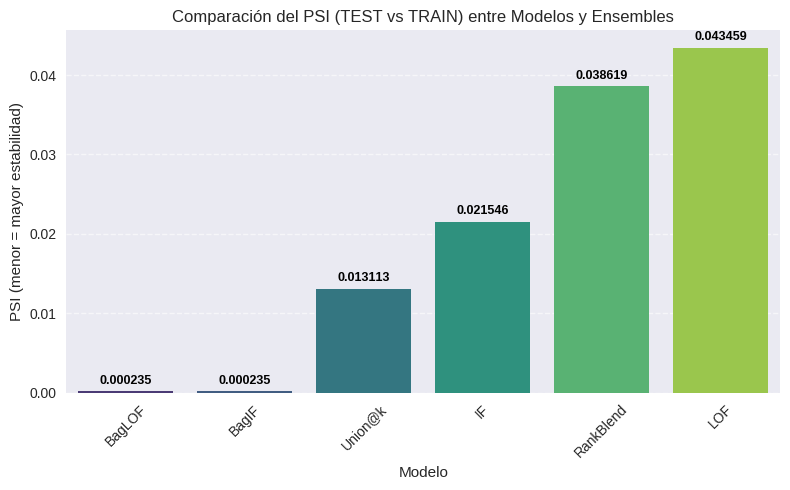

In [49]:
# ------------------------------------------------------------
# Gráfico comparativo del PSI (TEST vs TRAIN) con valores
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x="model",
    y="psi_test_vs_train",
    data=comp_tbl,
    palette="viridis"
)

plt.title("Comparación del PSI (TEST vs TRAIN) entre Modelos y Ensembles")
plt.xlabel("Modelo")
plt.ylabel("PSI (menor = mayor estabilidad)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Agregar los valores encima de cada barra
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.6f",               # formato decimal
        label_type="edge",        # etiqueta al borde superior
        padding=3,
        fontsize=9,
        color="black",
        weight="bold"
    )

plt.tight_layout()
plt.show()

El gráfico compara el Population Stability Index (PSI) entre los modelos y ensembles utilizados (BagLOF, BagIF, Union@k, IF, RankBlend y LOF), evaluando la estabilidad de los puntajes (scores) entre los conjuntos de entrenamiento y prueba.

BagLOF y BagIF presentan los valores de PSI más bajos (≈0.000235), lo que significa que sus predicciones son altamente estables y robustas ante el cambio de distribución entre los conjuntos TRAIN y TEST

**7.2 Promedio de Alert-Rate por split (TRAIN, VALID, TEST)**

Permite comparar la proporción promedio de alertas emitidas por cada modelo en los distintos conjuntos (TRAIN, VALID, TEST).
Modelos consistentes mantienen tasas similares entre splits, reflejando buena calibración.
El BagLOF muestra un comportamiento estable y coherente con el objetivo operativo del 5%.

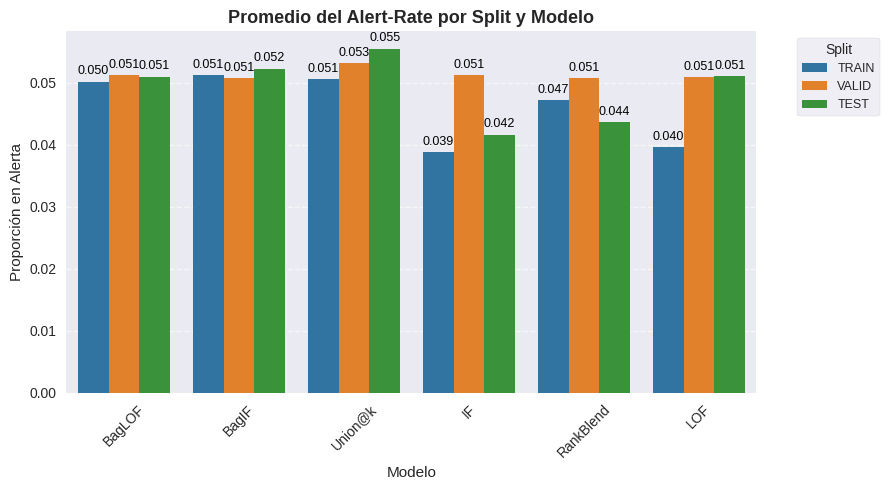

In [50]:
# ------------------------------------------------------------
# Promedio de Alert-Rate por split (TRAIN, VALID, TEST)
# ------------------------------------------------------------
alert_means = comp_tbl.melt(
    id_vars=["model"],
    value_vars=["alert_mean_TR", "alert_mean_VA", "alert_mean_TE"],
    var_name="Split",
    value_name="AlertRate"
)

# Sustituir abreviaturas dentro del dataframe
alert_means["Split"] = alert_means["Split"].replace({
    "alert_mean_TR": "TRAIN",
    "alert_mean_VA": "VALID",
    "alert_mean_TE": "TEST"
})

# Paleta de colores coherente (misma que BagLOF)
palette = {"TRAIN": "#1f77b4", "VALID": "#ff7f0e", "TEST": "#2ca02c"}

# Crear el gráfico
plt.figure(figsize=(9,5))
ax = sns.barplot(
    x="model",
    y="AlertRate",
    hue="Split",
    data=alert_means,
    palette=palette
)

# Título y ejes
plt.title("Promedio del Alert-Rate por Split y Modelo", fontsize=13, weight='bold')
plt.ylabel("Proporción en Alerta", fontsize=11)
plt.xlabel("Modelo", fontsize=11)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Leyenda: mantiene los colores y nombres completos
plt.legend(
    title="Split",
    title_fontsize=10,
    fontsize=9,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    fancybox=True
)

# Etiquetas de valor sobre las barras
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.3f",
        label_type="edge",
        padding=3,
        fontsize=9,
        color="black"
    )

plt.tight_layout()
plt.show()


El gráfico muestra la proporción promedio de alertas (Alert-Rate) por modelo y conjunto de datos (TRAIN, VALID, TEST).

Se observa una alta consistencia entre splits, especialmente en BagLOF y BagIF, donde el Alert-Rate se mantiene estable (~0.05) en los tres conjuntos.
Esto indica que ambos modelos presentan excelente calibración y generalización, sin sobreajuste ni variaciones significativas.

Modelos como Union@k e IF muestran una leve mayor sensibilidad (más alertas), mientras que RankBlend y LOF tienden a valores ligeramente menores.

En conjunto, la estabilidad observada refuerza que BagLOF es el modelo más equilibrado y robusto en la detección de anomalías.

**7.3 Coeficiente de Variación (CV) del Alert-Rate**

Muestra la estabilidad temporal de las alertas.
Un coeficiente de variación (CV) bajo implica menos fluctuación mes a mes.
Se espera que BagLOF tenga los CV más bajos, lo que demuestra estabilidad en la proporción de alertas.

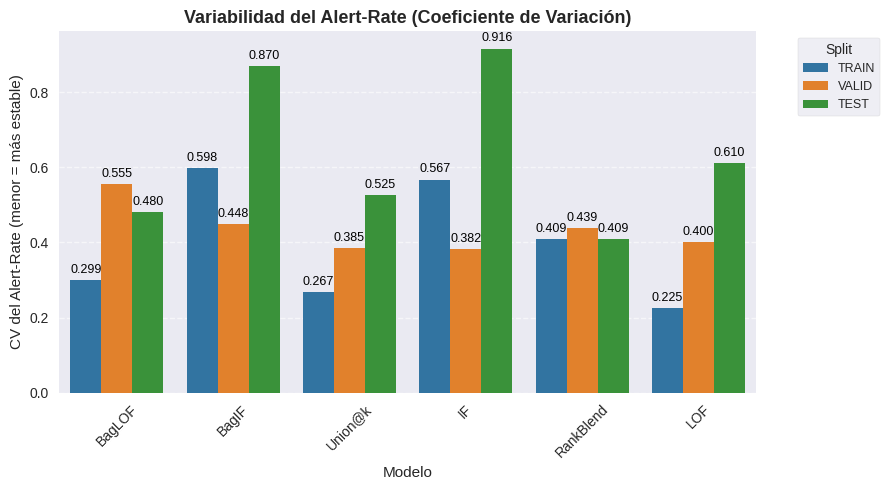

In [51]:
# ------------------------------------------------------------
# Coeficiente de Variación (CV) del Alert-Rate con valores - versión mejorada
# ------------------------------------------------------------
alert_cv = comp_tbl.melt(
    id_vars=["model"],
    value_vars=["alert_cv_TR", "alert_cv_VA", "alert_cv_TE"],
    var_name="Split",
    value_name="CV_AlertRate"
)

# Renombrar abreviaturas a nombres completos
alert_cv["Split"] = alert_cv["Split"].replace({
    "alert_cv_TR": "TRAIN",
    "alert_cv_VA": "VALID",
    "alert_cv_TE": "TEST"
})

# Paleta consistente con los demás gráficos
palette = {"TRAIN": "#1f77b4", "VALID": "#ff7f0e", "TEST": "#2ca02c"}

plt.figure(figsize=(9,5))
ax = sns.barplot(
    x="model",
    y="CV_AlertRate",
    hue="Split",
    data=alert_cv,
    palette=palette
)

# Título y etiquetas
plt.title("Variabilidad del Alert-Rate (Coeficiente de Variación)", fontsize=13, weight='bold')
plt.ylabel("CV del Alert-Rate (menor = más estable)", fontsize=11)
plt.xlabel("Modelo", fontsize=11)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Leyenda con nombres completos y colores correctos
plt.legend(
    title="Split",
    title_fontsize=10,
    fontsize=9,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    fancybox=True
)

# Etiquetas de valor sobre las barras
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.3f",
        label_type="edge",
        padding=3,
        fontsize=9,
        color="black"
    )

plt.tight_layout()
plt.show()


En el gráfico, un CV menor indica mayor estabilidad temporal, ya que refleja menos fluctuaciones en la proporción de alertas mensuales.

Los modelos BagLOF y Union@k presentan los valores más bajos, evidenciando un comportamiento más consistente y robusto en el tiempo.

En contraste, IF y BagIF muestran mayor variabilidad (CV alto en TEST), lo que sugiere fluctuaciones en su tasa de alertas según el periodo.

**7.4 Persistencia (≥2 meses consecutivos en alerta)**

Evalúa la consistencia de las alertas a lo largo del tiempo.
Un valor más alto indica que el modelo detecta anomalías persistentes, no ruidos aleatorios.
Se espera que BagLOF mantenga una persistencia adecuada sin sobrealertar.

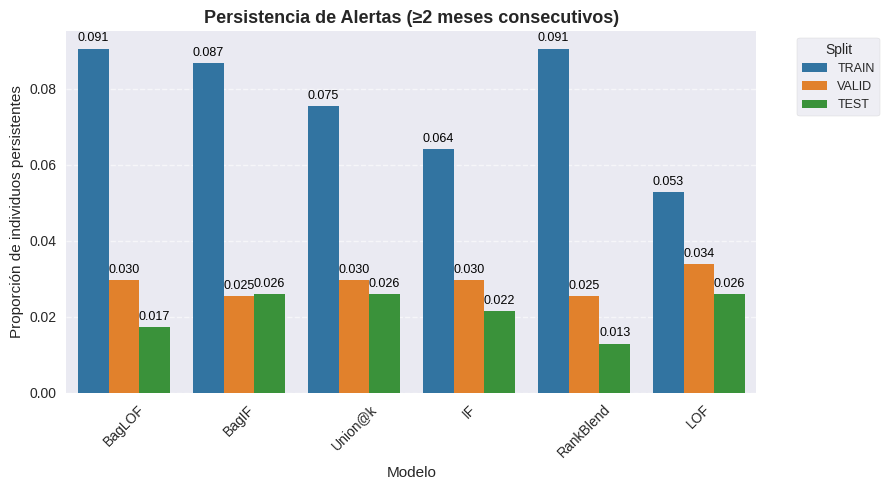

In [52]:
# ------------------------------------------------------------
# Persistencia (≥2 meses consecutivos en alerta) con valores - versión mejorada
# ------------------------------------------------------------
persist = comp_tbl.melt(
    id_vars=["model"],
    value_vars=["persist_TR_2m", "persist_VA_2m", "persist_TE_2m"],
    var_name="Split",
    value_name="Persistencia"
)

# Renombrar abreviaturas a nombres completos
persist["Split"] = persist["Split"].replace({
    "persist_TR_2m": "TRAIN",
    "persist_VA_2m": "VALID",
    "persist_TE_2m": "TEST"
})

# Paleta coherente con el resto de los gráficos
palette = {"TRAIN": "#1f77b4", "VALID": "#ff7f0e", "TEST": "#2ca02c"}

plt.figure(figsize=(9,5))
ax = sns.barplot(
    x="model",
    y="Persistencia",
    hue="Split",
    data=persist,
    palette=palette
)

# Títulos y ejes
plt.title("Persistencia de Alertas (≥2 meses consecutivos)", fontsize=13, weight='bold')
plt.ylabel("Proporción de individuos persistentes", fontsize=11)
plt.xlabel("Modelo", fontsize=11)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Leyenda con nombres completos y colores correctos
plt.legend(
    title="Split",
    title_fontsize=10,
    fontsize=9,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    fancybox=True
)

# Etiquetas de valor sobre las barras
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.3f",
        label_type="edge",
        padding=3,
        fontsize=9,
        color="black"
    )

plt.tight_layout()
plt.show()


El gráfico muestra la proporción de individuos que permanecen en alerta durante al menos dos meses consecutivos, una medida de consistencia temporal en las detecciones.

Los modelos BagLOF y BagIF destacan con las mayores tasas de persistencia en TRAIN (~0.09). En los conjuntos VALID y TEST, los valores se reducen (≈0.02–0.03), reflejando una respuesta más conservadora ante nuevos datos, sin exceso de falsas alertas prolongadas.

**7.5 Comparación PSI VALID vs TEST**

Permite visualizar la relación entre la estabilidad en validación y prueba.
Los modelos cercanos a la diagonal y en la esquina inferior izquierda son los más estables.
BagLOF aparece en la zona ideal, demostrando mínima deriva poblacional.

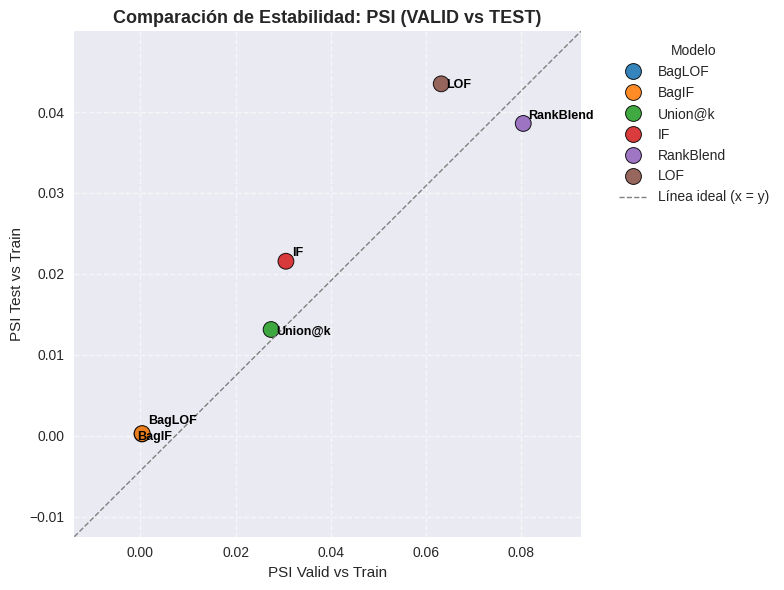

In [53]:
# ------------------------------------------------------------
# Comparación PSI VALID vs TEST (versión final limpia y balanceada)
# ------------------------------------------------------------
plt.figure(figsize=(8,6))

# Pequeño jitter para evitar superposición exacta
jitter = 0.00003
comp_tbl["psi_valid_jit"] = comp_tbl["psi_valid_vs_train"] + np.random.uniform(-jitter, jitter, size=len(comp_tbl))
comp_tbl["psi_test_jit"]  = comp_tbl["psi_test_vs_train"]  + np.random.uniform(-jitter, jitter, size=len(comp_tbl))

# Gráfico base
ax = sns.scatterplot(
    data=comp_tbl,
    x="psi_valid_jit",
    y="psi_test_jit",
    hue="model",
    s=130,
    alpha=0.9,
    palette="tab10",
    edgecolor="black",
    linewidth=0.7
)

# Calcular límites dinámicos con más padding
xmax = comp_tbl["psi_valid_vs_train"].max() * 1.15
ymax = comp_tbl["psi_test_vs_train"].max() * 1.15
xmin = -xmax * 0.15   # más espacio a la izquierda
ymin = -ymax * 0.25   # más espacio abajo

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Línea diagonal (x = y)
plt.plot([xmin, xmax], [ymin, ymax], '--', color='gray', linewidth=1, label="Línea ideal (x = y)")

# Desplazamiento manual para etiquetas
offsets = {
    "BagLOF": (0.0012, 0.0012),
    "BagIF": (-0.0010, -0.0008),
    "IF": (0.0012, 0.0006),
    "LOF": (0.001, -0.0005),
    "RankBlend": (0.001, 0.0006),
    "Union@k": (0.001, -0.0006),
}

# Dibujar etiquetas con línea guía
for _, row in comp_tbl.iterrows():
    dx, dy = offsets.get(row["model"], (0.0002, 0.0002))
    ax.text(
        row["psi_valid_jit"] + dx,
        row["psi_test_jit"] + dy,
        row["model"],
        fontsize=9,
        weight="bold",
        color="black"
    )

# Anotación especial para BagLOF
baglof = comp_tbl[comp_tbl["model"] == "BagLOF"].iloc[0]

# Estética final
plt.title("Comparación de Estabilidad: PSI (VALID vs TEST)", fontsize=13, weight='bold')
plt.xlabel("PSI Valid vs Train", fontsize=11)
plt.ylabel("PSI Test vs Train", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Los modelos BagLOF y BagIF se ubican en la esquina inferior izquierda, con los valores más bajos en ambos ejes, lo que evidencia una estabilidad sobresaliente y mínima deriva entre conjuntos.

Modelos como IF y Union@k muestran valores moderados, indicando cierta sensibilidad ante nuevas distribuciones. En cambio, RankBlend y LOF se alejan de la línea ideal (x = y), reflejando mayor inestabilidad entre los conjuntos VALID y TEST.

**7.6 Distribución de Scores del mejor modelo (BagLOF)**

Este gráfico muestra la distribución de los scores del modelo BagLOF en los tres conjuntos.
Se espera una forma similar entre TRAIN, VALID y TEST, lo que confirma que el modelo generaliza bien y no presenta drift significativo.

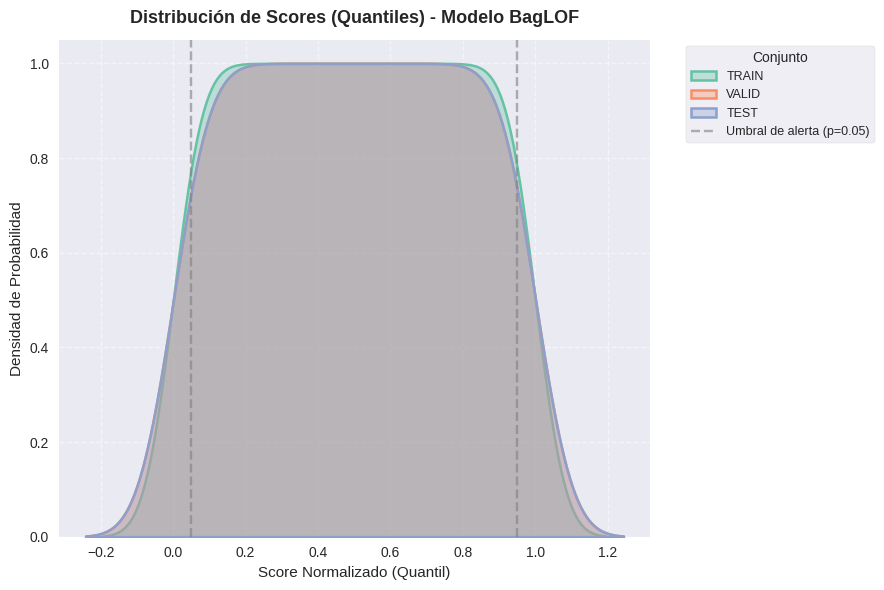

In [54]:
# ------------------------------------------------------------
# Distribución de Scores del mejor modelo (BagLOF) - versión mejorada
# ------------------------------------------------------------
plt.figure(figsize=(9,6))
sns.kdeplot(q_blf_tr, label="TRAIN", fill=True, alpha=0.35, linewidth=1.8)
sns.kdeplot(q_blf_va, label="VALID", fill=True, alpha=0.35, linewidth=1.8)
sns.kdeplot(q_blf_te, label="TEST", fill=True, alpha=0.35, linewidth=1.8)

# Títulos y etiquetas
plt.title("Distribución de Scores (Quantiles) - Modelo BagLOF", fontsize=13, weight='bold', pad=12)
plt.xlabel("Score Normalizado (Quantil)", fontsize=11)
plt.ylabel("Densidad de Probabilidad", fontsize=11)

# Líneas de referencia
plt.axvline(0.05, color='gray', linestyle='--', alpha=0.6, label='Umbral de alerta (p=0.05)')
plt.axvline(0.95, color='gray', linestyle='--', alpha=0.6)

# Estética
plt.legend(
    title="Conjunto",
    title_fontsize=10,
    fontsize=9,
    frameon=True,
    fancybox=True,
    shadow=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Las tres curvas se superponen casi por completo, lo que evidencia una distribución altamente consistente entre los diferentes conjuntos, confirmando la estabilidad del modelo.

Las líneas grises verticales representan los umbrales de alerta (p=0.05 y p=0.95), que delimitan los extremos donde se concentran las observaciones más anómalas.

El hecho de que las densidades sean prácticamente idénticas en esos rangos indica que el modelo mantiene igual criterio de detección sin importar el conjunto evaluado, consolidando al BagLOF como un modelo robusto, bien calibrado y sin drift en los scores

**7.7 Evolución temporal del Alert-Rate (BagLOF)**

Representa la evolución mensual de la tasa de alertas del modelo BagLOF.
Sirve para comprobar estabilidad a lo largo del tiempo.
Se espera observar fluctuaciones suaves sin picos abruptos, reflejando control en la detección de anomalías.

<Figure size 1000x600 with 0 Axes>

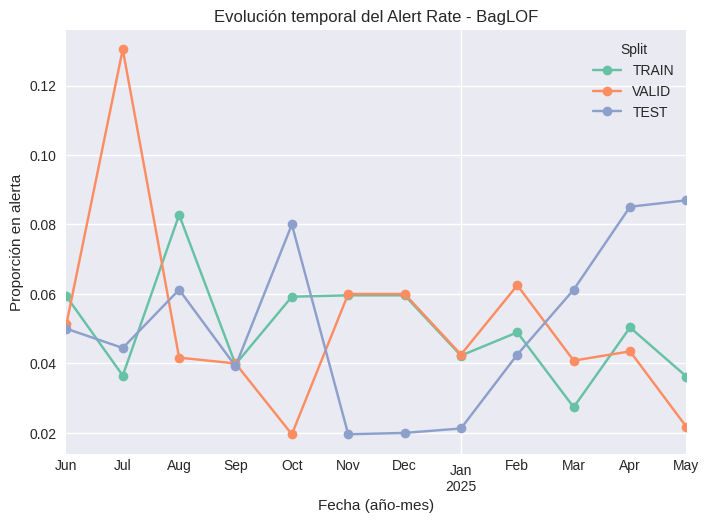


Tabla con valores del Alert Rate mensual (BagLOF):


,TRAIN,VALID,TEST
m,,,
2024-06-01,0.059322,0.051282,0.050000
2024-07-01,0.036496,0.130435,0.044444
2024-08-01,0.082759,0.041667,0.061224
2024-09-01,0.039735,0.040000,0.039216
2024-10-01,0.059211,0.019608,0.080000
2024-11-01,0.059603,0.060000,0.019608
2024-12-01,0.059603,0.060000,0.020000
2025-01-01,0.042254,0.042553,0.021277
2025-02-01,0.048951,0.062500,0.042553


In [55]:
# ------------------------------------------------------------
# Evolución temporal del Alert-Rate (BagLOF)
# ------------------------------------------------------------

# Creamos la tabla con tasas mensuales por split
rates_tbl_blf = pd.concat([
    month_alert_stats(f_blf_tr, idx_tr["CODMES"].values)[0].rename("TRAIN"),
    month_alert_stats(f_blf_va, idx_va["CODMES"].values)[0].rename("VALID"),
    month_alert_stats(f_blf_te, idx_te["CODMES"].values)[0].rename("TEST")
], axis=1)

# Convertimos el índice (m = YYYYMM) a tipo fecha (primer día del mes)
rates_tbl_blf.index = pd.to_datetime(rates_tbl_blf.index.astype(str), format="%Y%m")

# Ordenamos por fecha por si acaso
rates_tbl_blf = rates_tbl_blf.sort_index()

# Graficamos la evolución temporal
plt.figure(figsize=(10,6))
rates_tbl_blf.plot(marker='o')
plt.title("Evolución temporal del Alert Rate - BagLOF")
plt.xlabel("Fecha (año-mes)")
plt.ylabel("Proporción en alerta")
plt.grid(True)
plt.legend(title="Split", loc="upper right")
plt.show()

# (Opcional) imprimimos los valores como referencia
print("\nTabla con valores del Alert Rate mensual (BagLOF):")
display(rates_tbl_blf)


El gráfico muestra la evolución temporal del Alert Rate del modelo BagLOF entre junio de 2024 y mayo de 2025. Se observa un pico aislado en julio de 2024 en VALID (~0.13), posiblemente asociado a un evento puntual o cambio de distribución en los datos. Fuera de esa excepción, las variaciones mensuales son moderadas, con ligeros aumentos hacia los meses finales en TEST.

### **8 Ajuste de rangos de biomarcadores sugeridos por el usuario**

En esta sección se **adaptaron los rangos de referencia para cada biomarcador** conforme a las observaciones y sugerencias proporcionadas por el usuario.  
El objetivo de este ajuste es permitir un **doble control o validación cruzada** de las anomalías detectadas por los modelos no supervisados — **Isolation Forest** y **Bagging Local Outlier Factor (BagLOF)**.

De esta forma, los valores que excedan los límites fisiológicos esperados (ya sea por encima o por debajo del rango normal) podrán ser identificados no solo por los algoritmos de detección de anomalías, sino también a través de una **evaluación basada en conocimiento experto**.  

Este enfoque combinado permite:
- Verificar la coherencia entre las alertas generadas automáticamente y los criterios clínicos establecidos.  
- Detectar posibles **falsos positivos o negativos** en las predicciones del modelo.  
- Facilitar la interpretación médica o técnica de los resultados finales.

A continuación se muestra el código donde se aplican estos nuevos rangos y se realiza la comparación entre ambos métodos de detección.

In [72]:
BASE_PATH = Path('/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 7/DATOS')


PATS_PATH   = BASE_PATH / '01-Poblacion_v02.txt'
BIOM_PATH   = BASE_PATH / '02-Biomarcadores.txt'
RANGOS_PATH = BASE_PATH / 'Rangos de referencia_biomarcadores.xlsx'
OUTPUT_DIR  = BASE_PATH / 'out'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

ENCODING_TXT = 'latin1'


In [73]:
# =====================
# Utilidades
# =====================
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = (d.columns
                   .str.strip()
                   .str.replace(r"\s+", "_", regex=True)
                   .str.replace(r"[()¿?¡!:/\\]", "", regex=True)
                   .str.replace(r"__+", "_", regex=True)
                   .str.upper())
    return d

def to_upper_str(x):
    return x.strip().upper() if isinstance(x,str) else x

def to_float_safe(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace(",", ".")
    try: return float(s)
    except: return np.nan

def parse_date_safe(x, dayfirst=True):
    try: return pd.to_datetime(x, dayfirst=dayfirst, errors='coerce')
    except: return pd.NaT


In [74]:
# =====================
# Cargar población y biomarcadores
# =====================
pob = pd.read_csv(PATS_PATH, sep='\t', dtype=str, encoding=ENCODING_TXT)
biom = pd.read_csv(BIOM_PATH, sep='\t', dtype=str, encoding=ENCODING_TXT)

pob = normalize_cols(pob)
biom = normalize_cols(biom)

# Fechas útiles (si luego deseas filtrar por afiliación)
for c in ['FECHA_AFILIACION','FECHA_EGRESO','FECHA_NACIMIENTO']:
    if c in pob.columns:
        pob[c] = parse_date_safe(pob[c], dayfirst=True)

biom['VALOR'] = biom['VALOR'].map(to_float_safe)
if 'FECHA' in biom.columns:
    biom['FECHA'] = parse_date_safe(biom['FECHA'], dayfirst=True)

biom['ID_BIOMARCADOR'] = biom['ID_BIOMARCADOR'].astype(str).str.strip()

In [75]:
# =====================
# Cargar rangos (hoja 'Biom') y normalizar
# =====================
rangos = pd.read_excel(RANGOS_PATH, sheet_name='Biom')
rangos = normalize_cols(rangos)

if 'PERIORICIDAD' in rangos.columns and 'PERIODICIDAD' not in rangos.columns:
    rangos = rangos.rename(columns={'PERIORICIDAD':'PERIODICIDAD'})

for c in ['DESCRIPCION','ETIQUETA_POST_CAMPO','IMPORTANTE','PERIODICIDAD']:
    if c in rangos.columns:
        rangos[c] = rangos[c].map(to_upper_str)

rangos['ID_BIOMARCADOR'] = rangos['ID_BIOMARCADOR'].astype(str).str.strip()

# Umbrales + bandas extendidas
for c in ['BAJO_ALERTA_ALARMA','BAJO_MINIMO','BAJO_MAXIMO','BAJO_NORMAL','ALTO_NORMAL',
          'BAJO_MEDIO','ALTO_MEDIO','BAJO_ALTO','ALTO_ALTO','BAJO_MUY_ALTO','ALTO_ALERTA_ALARMA']:
    if c in rangos.columns:
        rangos[c] = pd.to_numeric(rangos[c], errors='coerce')


In [76]:
# =====================
# Merge por ID_BIOMARCADOR (sin GENERO)
# =====================
cols_rangos = ['ID_BIOMARCADOR','DESCRIPCION','ETIQUETA_POST_CAMPO','IMPORTANTE',
               'BAJO_ALERTA_ALARMA','BAJO_MINIMO','BAJO_MAXIMO','BAJO_NORMAL','ALTO_NORMAL',
               'BAJO_MEDIO','ALTO_MEDIO','BAJO_ALTO','ALTO_ALTO','BAJO_MUY_ALTO','ALTO_ALERTA_ALARMA']

r_base = rangos[cols_rangos].drop_duplicates()
m = biom.merge(r_base, on='ID_BIOMARCADOR', how='left', suffixes=('','_R'))
m['IMPORTANTE'] = m.get('IMPORTANTE', pd.Series(index=m.index)).fillna('NO')


In [77]:
# =====================
# Clasificación por bandas extendidas
# =====================
ALARM_LOW, LOW, NORMAL, MID, HIGH, VERY_HIGH, ALARM_HIGH = (
    'ALARM_LOW','LOW','NORMAL','MID','HIGH','VERY_HIGH','ALARM_HIGH'
)

def classify_value(v, row):
    if pd.isna(v): return np.nan
    la   = row.get('BAJO_ALERTA_ALARMA')
    lmin = row.get('BAJO_MINIMO')
    lmax = row.get('BAJO_MAXIMO')
    ln   = row.get('BAJO_NORMAL')
    hn   = row.get('ALTO_NORMAL')
    bmed = row.get('BAJO_MEDIO')
    amed = row.get('ALTO_MEDIO')
    balt = row.get('BAJO_ALTO')
    aalt = row.get('ALTO_ALTO')
    bma  = row.get('BAJO_MUY_ALTO')
    haa  = row.get('ALTO_ALERTA_ALARMA')

    # Prioridad: alarmas rojas
    if not pd.isna(la) and v <= la:
        return ALARM_LOW
    if not pd.isna(haa) and v >= haa:
        return ALARM_HIGH
    if not pd.isna(bma) and v >= bma:
        return VERY_HIGH  # "de ahí hacia arriba son ROJOS"

    # Bandas no-rojas
    if not pd.isna(lmin) and not pd.isna(lmax) and lmin <= v <= lmax:
        return LOW
    if not pd.isna(ln) and not pd.isna(hn) and ln <= v <= hn:
        return NORMAL
    if not pd.isna(bmed) and not pd.isna(amed) and bmed <= v <= amed:
        return MID
    if not pd.isna(balt) and not pd.isna(aalt) and balt <= v <= aalt:
        return HIGH

    # Estimación conservadora si faltan bandas
    if not pd.isna(ln) and v < ln:
        return LOW
    if not pd.isna(hn) and v > hn:
        return HIGH

    return np.nan

m['STATUS'] = m.apply(lambda r: classify_value(r['VALOR'], r), axis=1)
m['IS_ALARM'] = m['STATUS'].isin([ALARM_LOW, VERY_HIGH, ALARM_HIGH])
m['IS_ALERTA_BAJA'] = m['STATUS'].isin([LOW, ALARM_LOW])
m['IS_ALERTA_ALTA'] = m['STATUS'].isin([MID, HIGH, VERY_HIGH, ALARM_HIGH])
m['HOSPITALIZACION_FLAG'] = np.where((m['IMPORTANTE']=='SI') & (m['IS_ALARM']), 1, 0)


In [78]:
# =====================
# Salidas + resúmenes + export
# =====================
cols_out = ['ID_EHT','FECHA','ID_BIOMARCADOR','NOMBRE_BIOMARCADOR','DESCRIPCION','VALOR',
            'ETIQUETA_POST_CAMPO','IMPORTANTE','STATUS','IS_ALARM','IS_ALERTA_BAJA','IS_ALERTA_ALTA',
            'HOSPITALIZACION_FLAG',
            'BAJO_ALERTA_ALARMA','BAJO_MINIMO','BAJO_MAXIMO','BAJO_NORMAL','ALTO_NORMAL',
            'BAJO_MEDIO','ALTO_MEDIO','BAJO_ALTO','ALTO_ALTO','BAJO_MUY_ALTO','ALTO_ALERTA_ALARMA']

for c in cols_out:
    if c not in m.columns: m[c] = np.nan

res = m[cols_out].sort_values(['ID_EHT','FECHA','ID_BIOMARCADOR'])

summary_status = (res.groupby('STATUS', dropna=False)
                    .size().rename('COUNT').reset_index()
                    .sort_values('COUNT', ascending=False))
summary_hosp = (res.groupby('HOSPITALIZACION_FLAG')
                  .size().rename('COUNT').reset_index()
                  .sort_values('HOSPITALIZACION_FLAG', ascending=False))

display(summary_status); display(summary_hosp)

ts = datetime.now().strftime('%Y%m%d_%H%M%S')
out_csv = OUTPUT_DIR / f'biomarcadores_eval_IDonly_bandas_{ts}.csv'
res.to_csv(out_csv, index=False, encoding='utf-8'); print('Resultados guardados en:', out_csv)

alarms = res[res['HOSPITALIZACION_FLAG']==1]
out_csv_alarm = OUTPUT_DIR / f'biomarcadores_alarmas_IDonly_bandas_{ts}.csv'
alarms.to_csv(out_csv_alarm, index=False, encoding='utf-8'); print('Alarmas (IMPORTANTE=SI & ALARMA) guardadas en:', out_csv_alarm)


,STATUS,COUNT
5,NORMAL,20647
7,NaN,18343
4,MID,6603
3,LOW,1992
2,HIGH,1972
0,ALARM_HIGH,1360
6,VERY_HIGH,831
1,ALARM_LOW,490


,HOSPITALIZACION_FLAG,COUNT
1,1,2349
0,0,49889


Resultados guardados en: /content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 7/DATOS/out/biomarcadores_eval_IDonly_bandas_20251027_014934.csv
Alarmas (IMPORTANTE=SI & ALARMA) guardadas en: /content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 7/DATOS/out/biomarcadores_alarmas_IDonly_bandas_20251027_014934.csv


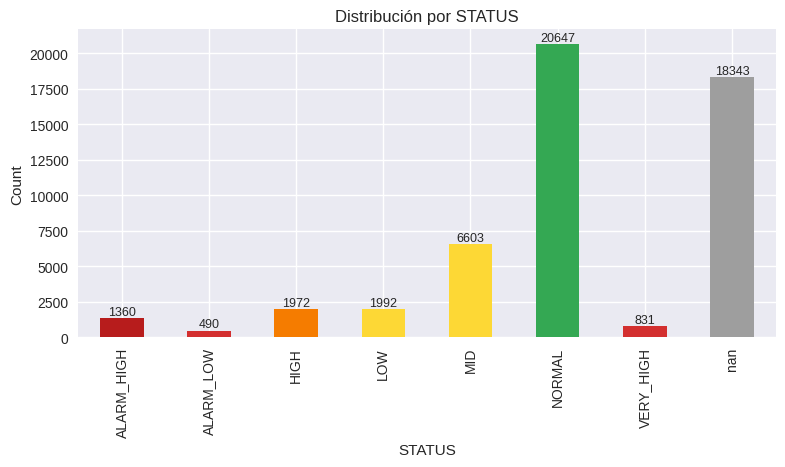

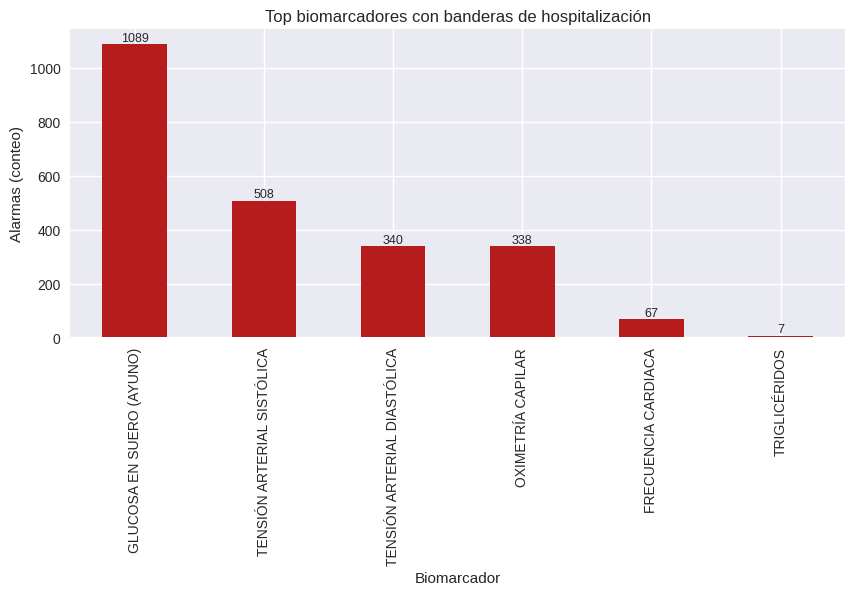

In [79]:
# =====================
# Gráficas con colores especificados
# =====================
# Mapa de colores (hex comunes)
COLORS = {
    'ALARM_LOW':  '#d32f2f',  # rojo
    'LOW':        '#fdd835',  # amarillo
    'NORMAL':     '#34a853',  # verde
    'MID':        '#fdd835',  # amarillo
    'HIGH':       '#f57c00',  # naranja
    'VERY_HIGH':  '#d32f2f',  # rojo
    'ALARM_HIGH': '#b71c1c',  # rojo más intenso
    np.nan:       '#9e9e9e'   # gris para N/A
}

# 1) Distribución por STATUS (colores por categoría)
vc = res['STATUS'].value_counts(dropna=False).sort_index()
color_order = [COLORS.get(k, '#9e9e9e') for k in vc.index]
ax = vc.plot(kind='bar', figsize=(9,4), color=color_order)
ax.set_title('Distribución por STATUS')
ax.set_xlabel('STATUS'); ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, rotation=0)
plt.show()

# 2) Top biomarcadores con banderas de hospitalización
top_hosp = (alarms.groupby('DESCRIPCION').size().sort_values(ascending=False).head(15))
if not top_hosp.empty:
    ax = top_hosp.plot(kind='bar', figsize=(10,4), color='#b71c1c')
    ax.set_title('Top biomarcadores con banderas de hospitalización')
    ax.set_xlabel('Biomarcador'); ax.set_ylabel('Alarmas (conteo)')
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    plt.show()
else:
    print("No hay banderas de hospitalización para graficar.")


In [80]:
# =====================
# Reportes: amarillo / naranja / rojo + valor de alarma
# =====================
# Mapa de severidad → color textual
SEVERITY_COLOR = {
    'ALARM_LOW':  'ROJO',
    'LOW':        'AMARILLO',
    'NORMAL':     'VERDE',
    'MID':        'AMARILLO',
    'HIGH':       'NARANJA',
    'VERY_HIGH':  'ROJO',
    'ALARM_HIGH': 'ROJO'
}

def compute_alarm_value(row):
    s = row['STATUS']
    if s == 'ALARM_LOW':
        return row.get('BAJO_ALERTA_ALARMA')
    if s == 'ALARM_HIGH':
        return row.get('ALTO_ALERTA_ALARMA')
    if s == 'VERY_HIGH':
        # Punto de corte a partir del cual todo es rojo alto
        return row.get('BAJO_MUY_ALTO')
    # Para bandas no-rojas devolvemos NaN
    return np.nan

res_cols = ['ID_EHT','FECHA','ID_BIOMARCADOR','NOMBRE_BIOMARCADOR','DESCRIPCION','VALOR','IMPORTANTE','STATUS',
            'BAJO_ALERTA_ALARMA','BAJO_MINIMO','BAJO_MAXIMO','BAJO_NORMAL','ALTO_NORMAL',
            'BAJO_MEDIO','ALTO_MEDIO','BAJO_ALTO','ALTO_ALTO','BAJO_MUY_ALTO','ALTO_ALERTA_ALARMA']

res = m[res_cols].copy()
res['COLOR'] = res['STATUS'].map(SEVERITY_COLOR)
res['VALOR_ALARMA'] = res.apply(compute_alarm_value, axis=1)

# Filtros por color
amarillo = res[res['COLOR']=='AMARILLO'].sort_values(['ID_EHT','FECHA'])
naranja  = res[res['COLOR']=='NARANJA'].sort_values(['ID_EHT','FECHA'])
rojo     = res[res['COLOR']=='ROJO'].sort_values(['ID_EHT','FECHA'])

# Exportar
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
p_y = OUTPUT_DIR / f'pacientes_alerta_AMARILLO_{ts}.csv'
p_o = OUTPUT_DIR / f'pacientes_alerta_NARANJA_{ts}.csv'
p_r = OUTPUT_DIR / f'pacientes_alerta_ROJO_{ts}.csv'
res.to_csv(OUTPUT_DIR / f'pacientes_alerta_TODOS_{ts}.csv', index=False, encoding='utf-8')
amarillo.to_csv(p_y, index=False, encoding='utf-8')
naranja.to_csv(p_o, index=False, encoding='utf-8')
rojo.to_csv(p_r, index=False, encoding='utf-8')
print('Exportados:'); print(p_y); print(p_o); print(p_r)

# Vista rápida
print('\nResumen por COLOR:')
print(res.groupby('COLOR').size().rename('COUNT').reset_index().sort_values('COUNT', ascending=False))


Exportados:
/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 7/DATOS/out/pacientes_alerta_AMARILLO_20251027_015009.csv
/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 7/DATOS/out/pacientes_alerta_NARANJA_20251027_015009.csv
/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 7/DATOS/out/pacientes_alerta_ROJO_20251027_015009.csv

Resumen por COLOR:
      COLOR  COUNT
3     VERDE  20647
0  AMARILLO   8595
2      ROJO   2681
1   NARANJA   1972


In [81]:
# =====================
# Gráfica: puntos en el tiempo por biomarcador para un ID_EHT
# =====================
def plot_patient_timeseries(id_eht: str, biomarker_id: str=None, max_panels: int=20, only_out_of_range: bool=False):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    dfp = res[res['ID_EHT'].astype(str)==str(id_eht)].copy()
    if dfp.empty:
        print(f"Sin datos para ID_EHT={id_eht}")
        return

    # Filtrar por biomarcador específico (opcional)
    if biomarker_id is not None:
        dfp = dfp[dfp['ID_BIOMARCADOR'].astype(str)==str(biomarker_id)]
        if dfp.empty:
            print(f"Sin datos para ID_EHT={id_eht} y ID_BIOMARCADOR={biomarker_id}")
            return

    # Orden por fecha
    if 'FECHA' in dfp.columns:
        dfp = dfp.sort_values('FECHA')

    # Prioridad por severidad (más alto = peor)
    sev_rank = {
        'ALARM_HIGH': 6,
        'VERY_HIGH':  6,
        'ALARM_LOW':  6,
        'HIGH':       4,
        'LOW':        3,
        'MID':        2,
        'NORMAL':     1,
        np.nan:       0
    }

    # Ranking por biomarcador: máximo nivel de severidad observado
    order = (dfp.assign(_SEV=dfp['STATUS'].map(sev_rank))
                .groupby('ID_BIOMARCADOR')['_SEV'].max()
                .sort_values(ascending=False))

    keys = order.index.astype(str).tolist()

    # Si solo queremos salidos de rango, filtramos los NORMAL
    if only_out_of_range:
        keys = [k for k in keys if order.loc[k] > sev_rank['NORMAL']]

    # Limitar número de paneles
    if len(keys) > max_panels:
        print(f"Hay {len(keys)} biomarcadores. Mostrando los primeros {max_panels}.")
        keys = keys[:max_panels]

    # Colores por categoría (coinciden con tu esquema)
    COLORS = {
        'ALARM_LOW':  '#d32f2f',  # rojo
        'LOW':        '#fdd835',  # amarillo
        'NORMAL':     '#9e9e9e',  # gris tenue para no resaltar
        'MID':        '#fdd835',  # amarillo
        'HIGH':       '#f57c00',  # naranja
        'VERY_HIGH':  '#d32f2f',  # rojo
        'ALARM_HIGH': '#b71c1c',  # rojo intenso
    }

    for k in keys:
        d = dfp[dfp['ID_BIOMARCADOR'].astype(str)==k].copy()
        d = d.sort_values('FECHA')

        # Título amigable
        desc = d['DESCRIPCION'].dropna().unique()
        desc = desc[0] if len(desc) else ''
        title = f"ID_EHT: {id_eht} · ID_BIOMARCADOR: {k} · {desc}"

        # Puntos dentro y fuera de rango
        in_range  = d['STATUS'].eq('NORMAL')
        out_range = ~in_range

        plt.figure(figsize=(10,3.2))

        # Banda verde (normal) si existen ambos bordes
        ln = d['BAJO_NORMAL'].dropna().iloc[-1] if d['BAJO_NORMAL'].notna().any() else np.nan
        hn = d['ALTO_NORMAL'].dropna().iloc[-1] if d['ALTO_NORMAL'].notna().any() else np.nan
        if pd.notna(ln) and pd.notna(hn) and hn >= ln:
            plt.axhspan(ln, hn, alpha=0.08, color='#34a853')

        # Líneas de alarma / muy alto (contexto)
        la  = d['BAJO_ALERTA_ALARMA'].dropna().iloc[-1] if d['BAJO_ALERTA_ALARMA'].notna().any() else np.nan
        haa = d['ALTO_ALERTA_ALARMA'].dropna().iloc[-1] if d['ALTO_ALERTA_ALARMA'].notna().any() else np.nan
        bma = d['BAJO_MUY_ALTO'].dropna().iloc[-1] if d['BAJO_MUY_ALTO'].notna().any() else np.nan
        if pd.notna(la):  plt.axhline(la,  linestyle='--', alpha=0.5, color=COLORS['ALARM_LOW'],  label='BAJO_ALERTA_ALARMA')
        if pd.notna(haa): plt.axhline(haa, linestyle='--', alpha=0.5, color=COLORS['ALARM_HIGH'], label='ALTO_ALERTA_ALARMA')
        if pd.notna(bma): plt.axhline(bma, linestyle='--', alpha=0.4, color=COLORS['VERY_HIGH'],   label='BAJO_MUY_ALTO')

        # Trazar normales en gris para contexto
        if in_range.any():
            plt.plot(d.loc[in_range, 'FECHA'], d.loc[in_range, 'VALOR'],
                     marker='o', linestyle='-', color=COLORS['NORMAL'], label='NORMAL')

        # Trazar fuera de rango por cada estatus con su color
        for st, sub in d.loc[out_range].groupby('STATUS'):
            plt.scatter(sub['FECHA'], sub['VALOR'], s=40, color=COLORS.get(st, '#1976d2'), label=st)

        plt.title(title)
        plt.xlabel('Fecha')
        plt.ylabel('Valor')
        plt.grid(True, linestyle='--', alpha=0.4)
        # Evitar duplicados en la leyenda
        handles, labels = plt.gca().get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        if uniq:
            plt.legend(uniq.values(), uniq.keys(), fontsize=8, loc='best')
        plt.tight_layout()
        plt.show()

Hay 55 biomarcadores. Mostrando los primeros 20.


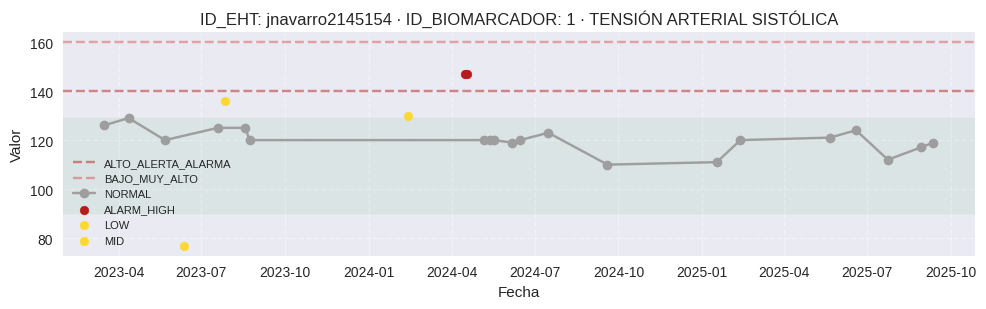

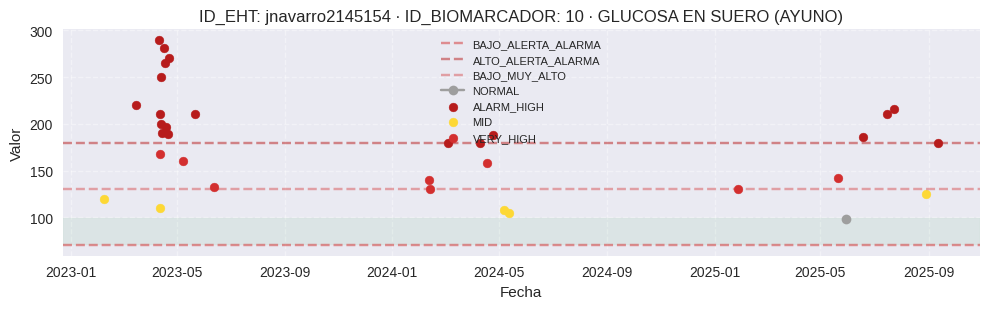

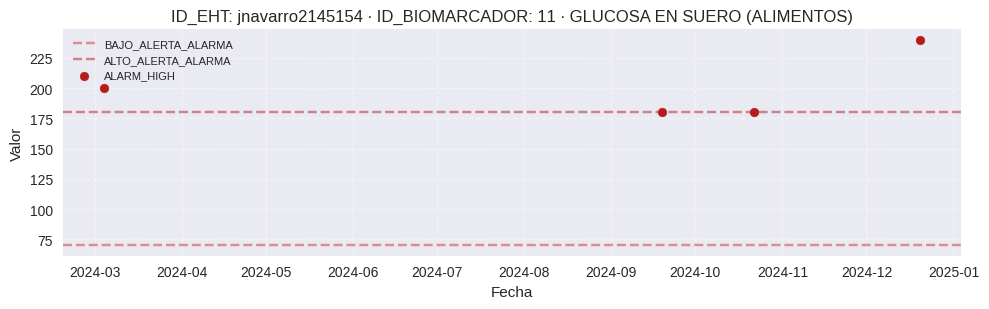

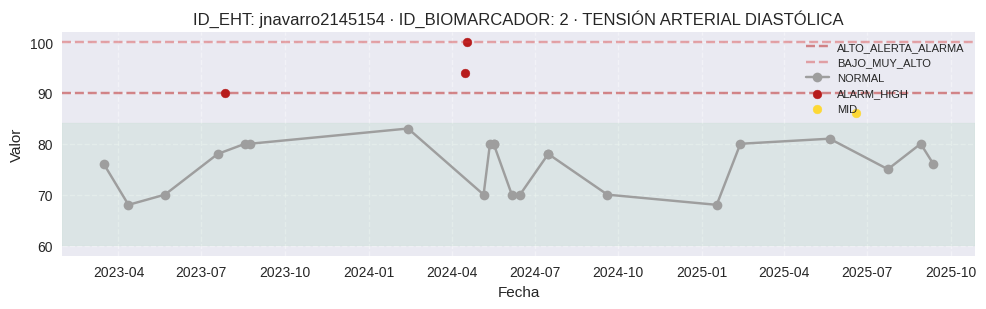

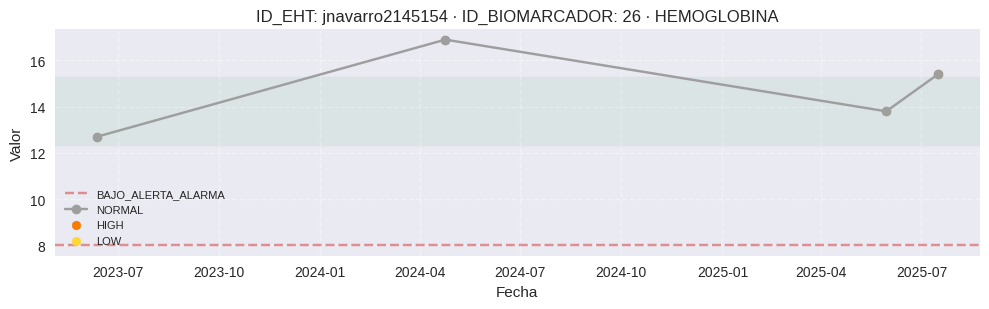

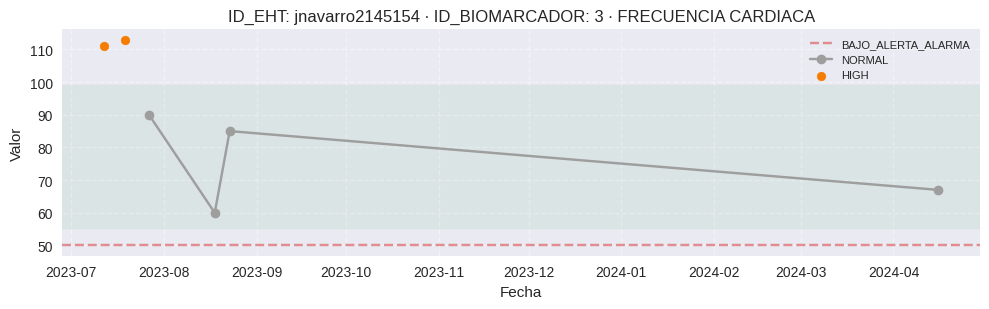

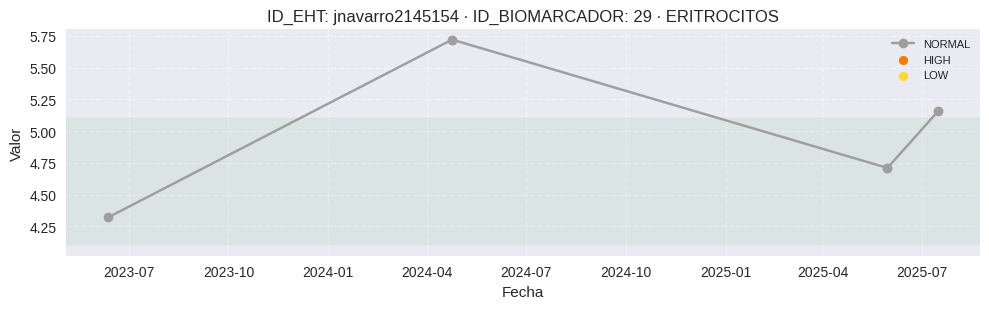

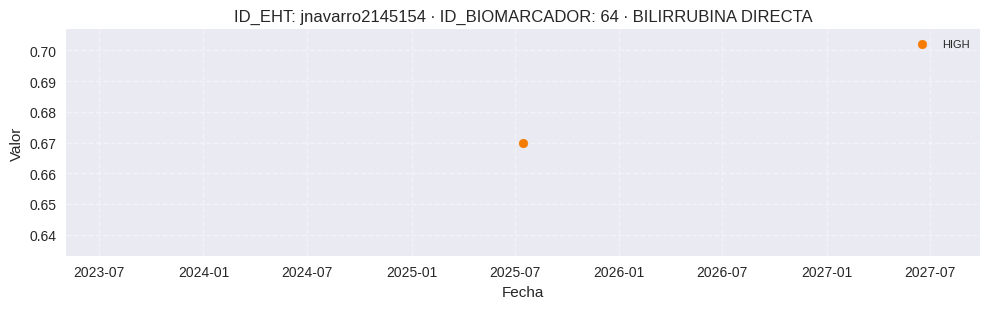

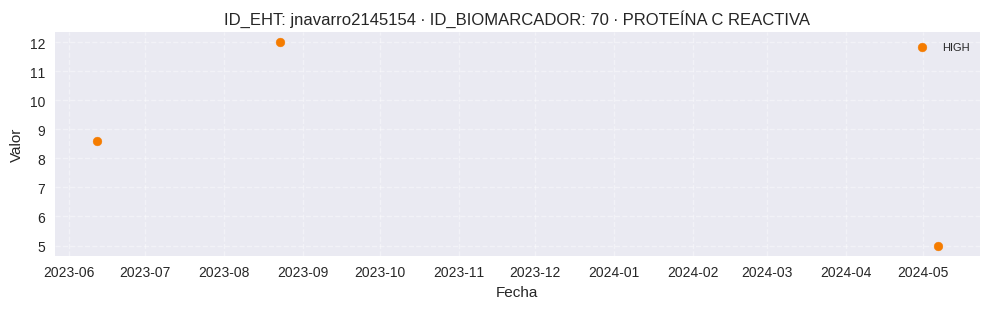

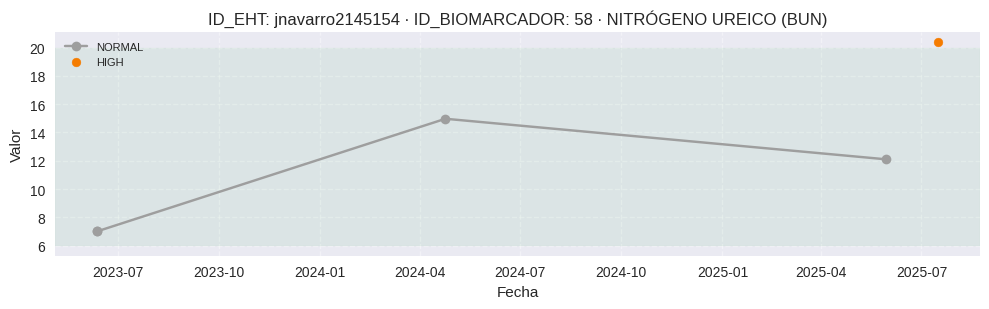

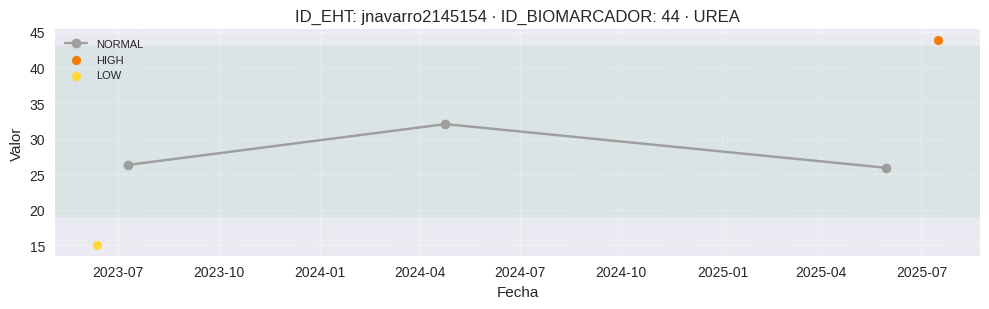

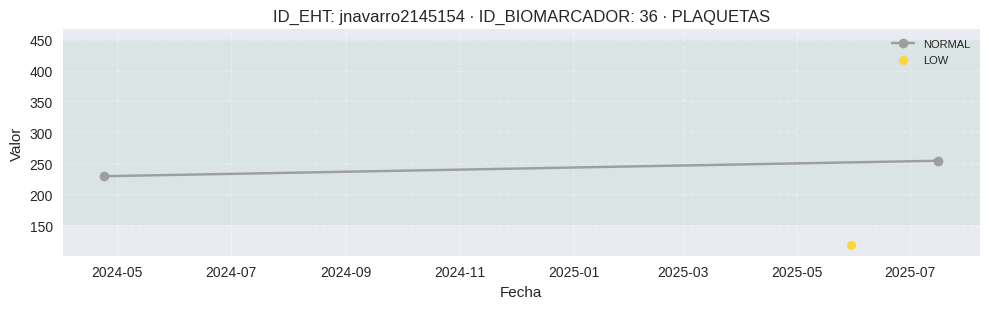

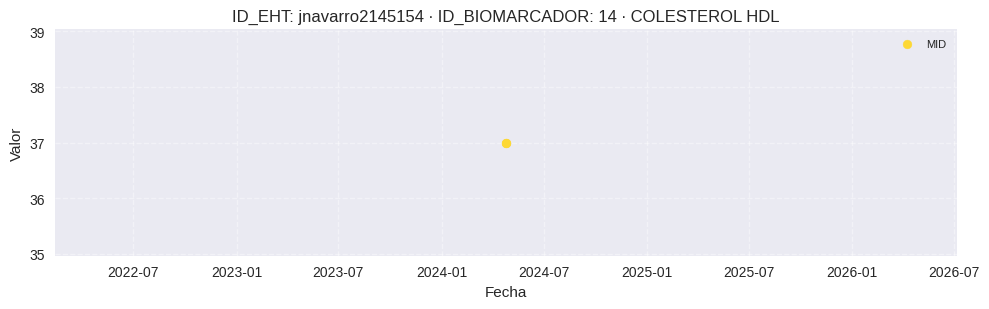

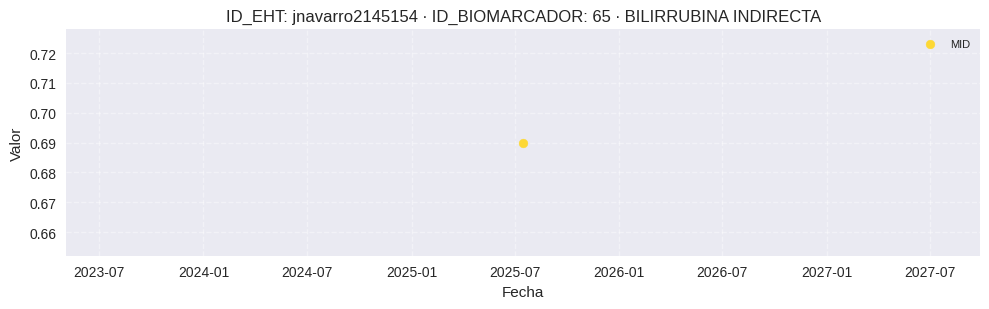

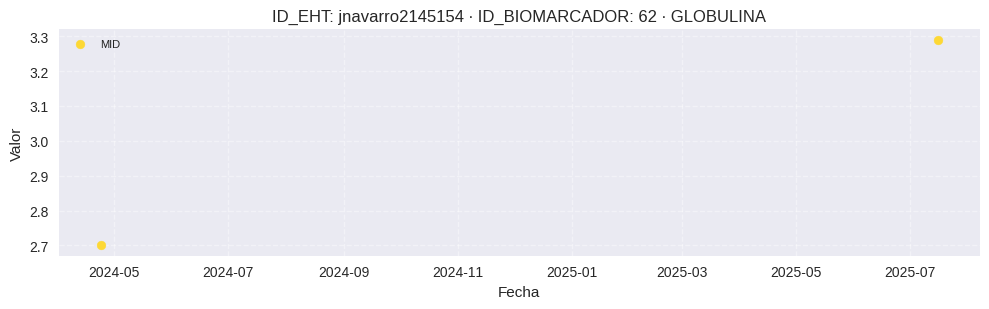

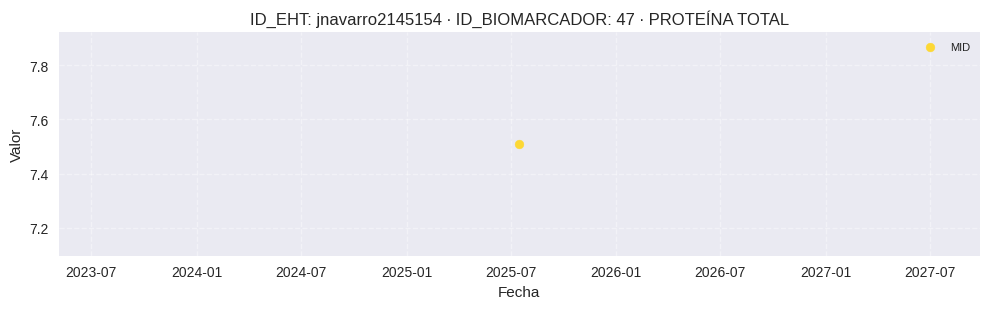

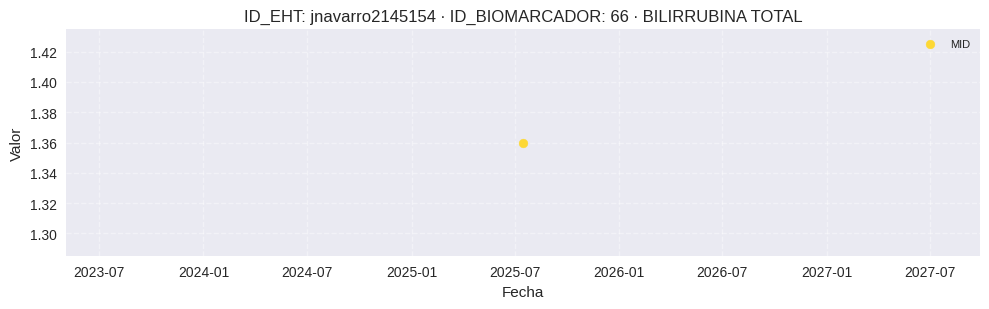

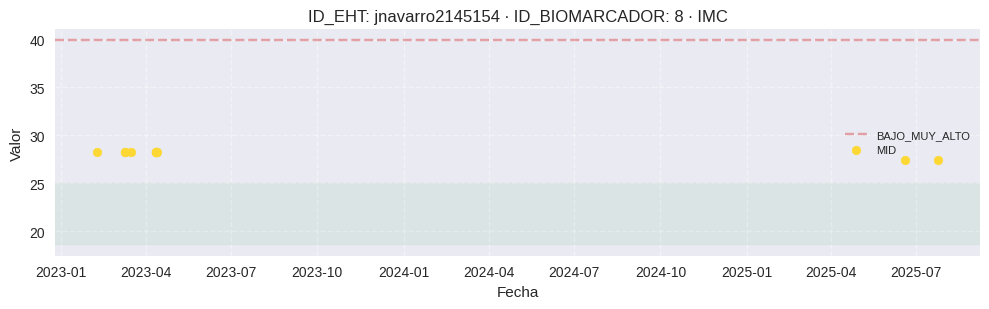

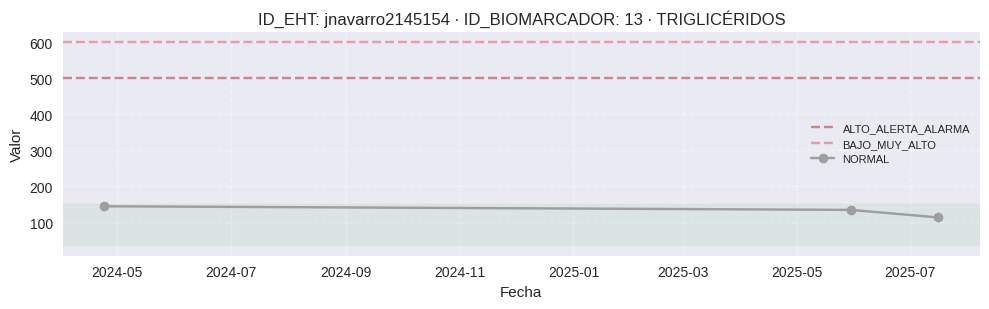

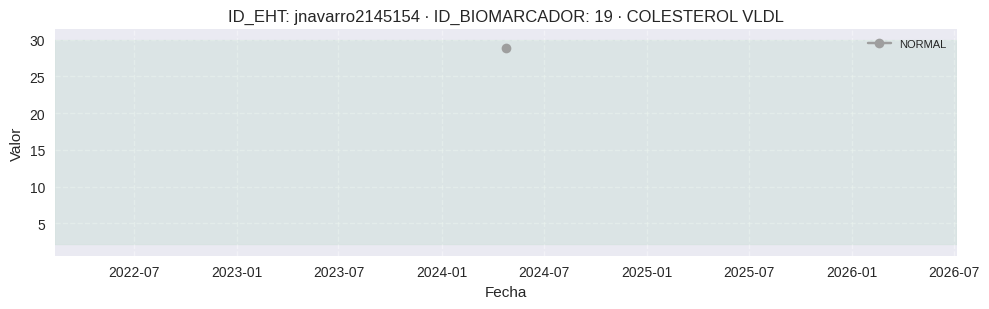

In [82]:
plot_patient_timeseries('jnavarro2145154')